# Global Burden Of Diseases 1970 - 2010

In [1]:
import pandas as pd
import numpy as np

import awoc
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write = True 

from scipy import stats
import seaborn as sns
sns.set(palette='deep')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

import plotly.express as px

import plotly.graph_objects as go
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import norm
my_world = awoc.AWOC()
#output_notebook() #specify the Bokeh plots should be embedded within the Jupyter notebook

import warnings
warnings.filterwarnings('ignore')
import csv
import os

### What is my portfolio exploring?
#### Why did the number of deaths increases eventhough they have been medical advancements?
#### Could this be because of decrease in county GDP?
#### Could this be because of decrease in public/health expenditure?
#### Could this be because of increases in the numbers of diseases?


### Definitions
#### Correlation A relationship between two events based on pattern of change.
#### Causation: A change in one variable leads to a change in another variable.
#### Gross Domestice Product (GDP): A measure of the size and health of a country's economic health over a period of time.
#### Health expenditure per capita/Public health expenditure per capita: Government expenditure on health as a percentage of total government expenditure.


In [2]:
Global_Burden_of_Disease_df = pd.read_csv('c:/Users/Asus/Desktop/Juypter Notebook/Data/IHME_GBD_2010_MORTALITY_AGE_SPECIFIC_BY_COUNTRY_1970_2010.csv', encoding='cp1252')

In [3]:
print('number of unique countries:',len(Global_Burden_of_Disease_df['Country Name'].unique()))
display(Global_Burden_of_Disease_df.info())
display(Global_Burden_of_Disease_df.describe())

number of unique countries: 187
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58905 entries, 0 to 58904
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Country Code            58905 non-null  object
 1   Country Name            58905 non-null  object
 2   Year                    58905 non-null  int64 
 3   Age Group               58905 non-null  object
 4   Sex                     58905 non-null  object
 5   Number of Deaths        58905 non-null  object
 6   Death Rate Per 100,000  58905 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.1+ MB


None

Year
count  58905.000000
mean    1990.000000
std       14.142256
min     1970.000000
25%     1980.000000
50%     1990.000000
75%     2000.000000
max     2010.000000

In [4]:
#removing comma
Global_Burden_of_Disease_df['Number of Deaths'] = Global_Burden_of_Disease_df['Number of Deaths'].str.replace(',', '')
Global_Burden_of_Disease_df['Death Rate Per 100,000'] = Global_Burden_of_Disease_df['Death Rate Per 100,000'].str.replace(',', '')
Global_Burden_of_Disease_df.head(3)


Country Code Country Name  Year Age Group     Sex Number of Deaths  \
0          AFG  Afghanistan  1970  0-6 days    Male            19241   
1          AFG  Afghanistan  1970  0-6 days  Female            12600   
2          AFG  Afghanistan  1970  0-6 days    Both            31840   

  Death Rate Per 100,000  
0              318292.90  
1              219544.20  
2              270200.70

In [5]:
#Checking to see if number of deaths and death rate per 100,000 contains any str values.
#If no str present I will change the data type for these columns.
Global_Burden_of_Disease_df['Death Rate Per 100,000'].unique()
Global_Burden_of_Disease_df['Number of Deaths'].unique()
#No str seems to be present.
Global_Burden_of_Disease_df['Number of Deaths'] = Global_Burden_of_Disease_df['Number of Deaths'].astype(int)
Global_Burden_of_Disease_df['Death Rate Per 100,000'] = Global_Burden_of_Disease_df['Death Rate Per 100,000'].astype(float)
display(Global_Burden_of_Disease_df.info())
#Double checking to see if there are any null values.
#Not expecting any due to information from .info
display(Global_Burden_of_Disease_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58905 entries, 0 to 58904
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country Code            58905 non-null  object 
 1   Country Name            58905 non-null  object 
 2   Year                    58905 non-null  int64  
 3   Age Group               58905 non-null  object 
 4   Sex                     58905 non-null  object 
 5   Number of Deaths        58905 non-null  int32  
 6   Death Rate Per 100,000  58905 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 2.9+ MB


None

Country Code              0
Country Name              0
Year                      0
Age Group                 0
Sex                       0
Number of Deaths          0
Death Rate Per 100,000    0
dtype: int64

In [6]:
#checking my columns that have a object Dtype, to see if there are any animalies in the values.
print('Number of unique years:',len(Global_Burden_of_Disease_df['Year'].unique()))
print('Number of unique age group:',len(Global_Burden_of_Disease_df['Age Group'].unique()))
print('Number of unique sex:',len(Global_Burden_of_Disease_df['Sex'].unique()))
print('Number of unique countries:',len(Global_Burden_of_Disease_df['Country Name'].unique()))
#There seems to be an spelling mistakes with the names of the countries.

Number of unique years: 5
Number of unique age group: 21
Number of unique sex: 3
Number of unique countries: 187


## Cleaning Data

In [7]:
#Correcting Country name section.
# Use awoc library to identify names of all countries-> countries variable.
# countries that are in both the above list from the country name column are added to list of country list.
#missing countries= countries that are in country name column but not in list of countries.
world = awoc.AWOC()
countries = world.get_countries()
list_of_countries = []
for country in countries:
    list_of_countries.append(country['Country Name'])
list_of_countries

missing_countries = []    
for country_name in Global_Burden_of_Disease_df['Country Name'].unique():
    if country_name not in list_of_countries:
#         print(f"{country_name} is NOT in the list.")
        missing_countries.append(country_name)
missing_countries

corrections = {
    'Brunei Darussalam': 'Brunei',
    "Cote d'Ivoire": 'Ivory Coast',
    'Congo, the Democratic Republic of the': 'Democratic Republic of the Congo',
    'Congo': 'Republic of the Congo',
    'Micronesia, Federated States of': 'Micronesia',
    'Iran, Islamic Republic of': 'Iran',
    'Korea, Republic of': 'South Korea',
    "Lao People's Democratic Republic": 'Laos',
    'Libyan Arab Jamahiriya': 'Libya',
    'Macedonia, the Former Yugoslav Republic of': 'North Macedonia',
    "Korea, Democratic People's Republic of": 'North Korea',
    'Occupied Palestinian Territory': 'Palestine',
    'Russian Federation': 'Russia',
    'Syrian Arab Republic': 'Syria',
    'Timor-Leste': 'East Timor',
    'Tanzania, United Republic of': 'Tanzania',
    'Viet Nam': 'Vietnam'
}

Global_Burden_of_Disease_df['Country Name'] = Global_Burden_of_Disease_df['Country Name'].replace(corrections)
'Republic of the Congo' in list(Global_Burden_of_Disease_df['Country Name'].unique())
Global_Burden_of_Disease_df[Global_Burden_of_Disease_df['Country Name'] == 'North Macedonia']

Country Code     Country Name  Year  Age Group     Sex  \
34650          MKD  North Macedonia  1970   0-6 days    Male   
34651          MKD  North Macedonia  1970   0-6 days  Female   
34652          MKD  North Macedonia  1970   0-6 days    Both   
34653          MKD  North Macedonia  1970  7-27 days    Male   
34654          MKD  North Macedonia  1970  7-27 days  Female   
...            ...              ...   ...        ...     ...   
34960          MKD  North Macedonia  2010  80+ years  Female   
34961          MKD  North Macedonia  2010  80+ years    Both   
34962          MKD  North Macedonia  2010   All ages    Male   
34963          MKD  North Macedonia  2010   All ages  Female   
34964          MKD  North Macedonia  2010   All ages    Both   

       Number of Deaths  Death Rate Per 100,000  
34650               505                136092.3  
34651               364                105599.0  
34652               869                121399.3  
34653               222                 20233.5  
34654               188                 18470.7  
...                 ...                     ...  
34960              3631                 13259.1  
34961              6006                 14155.2  
34962              9926                   961.6  
34963              9302                   904.4  
34964             19228                   933.0  

[315 rows x 7 columns]

In [8]:
#Drop columns that I think are unecessary, country code column.
Global_Burden_of_Disease_df_cleaning = Global_Burden_of_Disease_df.copy()
Global_Burden_of_Disease_df_cleaning = Global_Burden_of_Disease_df_cleaning#.drop(columns='Country Code')
Global_Burden_of_Disease_df_cleaning.head(3)




Country Code Country Name  Year Age Group     Sex  Number of Deaths  \
0          AFG  Afghanistan  1970  0-6 days    Male             19241   
1          AFG  Afghanistan  1970  0-6 days  Female             12600   
2          AFG  Afghanistan  1970  0-6 days    Both             31840   

   Death Rate Per 100,000  
0                318292.9  
1                219544.2  
2                270200.7

In [9]:
#I am going to be checking the overall trend of my data based on the different factors stated in my question.
Global_Burden_of_Disease_df_manipulation = Global_Burden_of_Disease_df_cleaning.copy()

#When looking at the changes made based on countries. All ages (Age Group) and Both (Sex) will be used.
#Therefore the only variable that is changing/affecting number of deaths is Countries.
Global_Burden_of_Disease_df_country = Global_Burden_of_Disease_df_manipulation.copy()
Global_Burden_of_Disease_df_country_age_group_mask = Global_Burden_of_Disease_df_country['Age Group'] == 'All ages'

#Global_Burden_of_Disease_df_country_sex_mask = Global_Burden_of_Disease_df_country['Sex'] == 'Both'
Global_Burden_of_Disease_df_country = Global_Burden_of_Disease_df_country[Global_Burden_of_Disease_df_country_age_group_mask]
Global_Burden_of_Disease_df_country = Global_Burden_of_Disease_df_country.loc[Global_Burden_of_Disease_df_country['Sex'] == 'Both']

#Now that I have filtered age group and sex colummn.
#Now I will create a dataframe with the columns: County Name, Number of deaths, death rate per 100,000.
#Global_Burden_of_Disease_df_country = Global_Burden_of_Disease_df_country.loc[:,['Country Name', 'Year', 'Number of Deaths', 'Death Rate Per 100,000']]
Global_Burden_of_Disease_df_country.head(3)




Country Code Country Name  Year Age Group   Sex  Number of Deaths  \
62           AFG  Afghanistan  1970  All ages  Both            291837   
125          AFG  Afghanistan  1980  All ages  Both            292045   
188          AFG  Afghanistan  1990  All ages  Both            200636   

     Death Rate Per 100,000  
62                   2432.3  
125                  2026.8  
188                  1486.2

In [10]:
#Replacing North Macedonia with Macedonia, beacuse north macedonia is not in the awoc library.
#A continent cannot be assigned to a continent.
for country in Global_Burden_of_Disease_df_country['Country Name'].replace({"North Macedonia":'Macedonia'}):
    Continent_of_data = my_world.get_country_continent_name(country)
    print(f'"{Continent_of_data}",')



"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"South America",
"South America",
"South America",
"South America",
"South America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",


In [11]:
#percentage change based on country.
Global_Burden_of_Disease_df_country['Number of Deaths pct change'] = Global_Burden_of_Disease_df_country['Number of Deaths'].pct_change()*100
Global_Burden_of_Disease_df_country['Death Rate Per 100,000 pct change'] = Global_Burden_of_Disease_df_country['Death Rate Per 100,000'].pct_change()*100

In [12]:
#Aim is to create a column that shows the percentage change in Number of death and Death rate per 100,000 column, for each countries.
#First I created a column, to identify if the countries matched. 
#The reason for this is that I wanted the percentage change value to be created if only the countries are the same.
#After this I had to create a series that revered the above dataframe.
#if country match column was used to create the percentage change column values are produced when country match values = 'False'.
Country_match = Global_Burden_of_Disease_df_country['Country Name'] == Global_Burden_of_Disease_df_country['Country Name'].shift()                             
no_match_Country_match = ~Country_match   
Global_Burden_of_Disease_df_country.loc[no_match_Country_match, 'Number of Deaths pct change'] = 0
Global_Burden_of_Disease_df_country.loc[no_match_Country_match, 'Death Rate Per 100,000 pct change'] = 0



Global_Burden_of_Disease_df_country.head(3)

Country Code Country Name  Year Age Group   Sex  Number of Deaths  \
62           AFG  Afghanistan  1970  All ages  Both            291837   
125          AFG  Afghanistan  1980  All ages  Both            292045   
188          AFG  Afghanistan  1990  All ages  Both            200636   

     Death Rate Per 100,000  Number of Deaths pct change  \
62                   2432.3                     0.000000   
125                  2026.8                     0.071273   
188                  1486.2                   -31.299628   

     Death Rate Per 100,000 pct change  
62                            0.000000  
125                         -16.671463  
188                         -26.672587

In [13]:
#Creating a new column that shows the continents for each countries.
for country in Global_Burden_of_Disease_df_country['Country Name'].replace({"North Macedonia":'Macedonia'}):
    Continent_of_data = my_world.get_country_continent_name(country)
    print(f'"{Continent_of_data}",')
    

"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"South America",
"South America",
"South America",
"South America",
"South America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",


In [14]:
Continents_gbd_country = [
    "Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"South America",
"South America",
"South America",
"South America",
"South America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"North America",
"North America",
"North America",
"North America",
"North America",
"South America",
"South America",
"South America",
"South America",
"South America",
"South America",
"South America",
"South America",
"South America",
"South America",
"North America",
"North America",
"North America",
"North America",
"North America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"North America",
"North America",
"North America",
"North America",
"North America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"South America",
"South America",
"South America",
"South America",
"South America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"South America",
"South America",
"South America",
"South America",
"South America",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"North America",
"North America",
"North America",
"North America",
"North America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"North America",
"North America",
"North America",
"North America",
"North America",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"South America",
"South America",
"South America",
"South America",
"South America",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"North America",
"South America",
"South America",
"South America",
"South America",
"South America",
"North America",
"North America",
"North America",
"North America",
"North America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"North America",
"North America",
"North America",
"North America",
"North America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"North America",
"North America",
"North America",
"North America",
"North America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"North America",
"North America",
"North America",
"North America",
"North America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"North America",
"North America",
"North America",
"North America",
"North America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",
"South America",
"South America",
"South America",
"South America",
"South America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"South America",
"South America",
"South America",
"South America",
"South America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"North America",
"North America",
"North America",
"North America",
"North America",
"Africa",
"Africa",
"Africa",

"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"South America",
"South America",
"South America",
"South America",
"South America",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"North America",
"North America",
"North America",
"North America",
"North America",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Europe",
"Europe",
"Europe",
"Europe",
"Europe",
"South America",
"South America",
"South America",
"South America",
"South America",
"North America",
"North America",
"North America",
"North America",
"North America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"North America",
"North America",
"North America",
"North America",
"North America",
"South America",
"South America",
"South America",
"South America",
"South America",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Oceania",
"Asia",
"Asia",
"Asia",
"Asia",
"Asia",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa",
"Africa"    
]
Global_Burden_of_Disease_df_country.reset_index(drop=True, inplace=True)

Global_Burden_of_Disease_df_country['Continents'] = pd.DataFrame(Continents_gbd_country, columns=['Continents'])  
Global_Burden_of_Disease_df_country.head(3)

Country Code Country Name  Year Age Group   Sex  Number of Deaths  \
0          AFG  Afghanistan  1970  All ages  Both            291837   
1          AFG  Afghanistan  1980  All ages  Both            292045   
2          AFG  Afghanistan  1990  All ages  Both            200636   

   Death Rate Per 100,000  Number of Deaths pct change  \
0                  2432.3                     0.000000   
1                  2026.8                     0.071273   
2                  1486.2                   -31.299628   

   Death Rate Per 100,000 pct change Continents  
0                           0.000000       Asia  
1                         -16.671463       Asia  
2                         -26.672587       Asia

In [15]:
#Country_match = Global_Burden_of_Disease_df_country['Country Name'] == Global_Burden_of_Disease_df_country['Country Name'].shift()                             
#no_match_Country_match = ~Country_match   
#Global_Burden_of_Disease_df_country.loc[no_match_Country_match, 'Number of Deaths pct change'] = 0
#Global_Burden_of_Disease_df_country.loc[no_match_Country_match, 'Death Rate Per 100,000 pct change'] = 0
#Global_Burden_of_Disease_df_country
#def country_name_match():
    #Country_match= []
    #Country_match = df['Country Name'] == df['Country Name'].shift()
    #no_match_Country_match = []
    #no_match_Country_match = ~Country_match 
    

I have decided that Global_Burden_of_Disease_df_country will be used as a baseline to see if there is a significant difference in the number of death based on gender and age group. I need to do more research to see if this is possible.

Percentage change will be used to present the changes in the value in a format that is much easier to understand, instead of using the actual values.

In [16]:
# Aim is to creat a dataframe showing the changes in the number of deaths andDeath Rate Per 100,000, based on Sex.
Global_Burden_of_Disease_df_manipulation
Global_Burden_of_Disease_df_Sex = Global_Burden_of_Disease_df_manipulation.copy()
Global_Burden_of_Disease_df_Sex_age_group_mask = Global_Burden_of_Disease_df_Sex['Age Group'] == 'All ages'
Global_Burden_of_Disease_df_Sex = Global_Burden_of_Disease_df_Sex[Global_Burden_of_Disease_df_Sex_age_group_mask]
Global_Burden_of_Disease_df_Female = Global_Burden_of_Disease_df_Sex.loc[Global_Burden_of_Disease_df_Sex['Sex'] == 'Female']
Global_Burden_of_Disease_df_Male = Global_Burden_of_Disease_df_Sex.loc[Global_Burden_of_Disease_df_Sex['Sex'] == 'Male']
Global_Burden_of_Disease_df_Female 
Global_Burden_of_Disease_df_Male
#Made two dataframes for both sex, similar to the country dataframes.
#Adding percentage change to the Global_Burden_of_Disease_df_Female.
Global_Burden_of_Disease_df_Female['Number of Deaths pct change'] = Global_Burden_of_Disease_df_Female.loc[:, ('Number of Deaths')].pct_change()*100
Global_Burden_of_Disease_df_Female['Death Rate Per 100,000 pct change'] = Global_Burden_of_Disease_df_Female.loc[:,('Death Rate Per 100,000')].pct_change()*100
Country_match = Global_Burden_of_Disease_df_Female.loc[:, ('Country Name')] == Global_Burden_of_Disease_df_Female['Country Name'].shift()                             
no_match_Country_match = ~Country_match   
Global_Burden_of_Disease_df_Female.loc[no_match_Country_match, 'Number of Deaths pct change'] = 0
Global_Burden_of_Disease_df_Female.loc[no_match_Country_match, 'Death Rate Per 100,000 pct change'] = 0
Global_Burden_of_Disease_df_Female
#Adding percentage change to the Global_Burden_of_Disease_df_Male.
Global_Burden_of_Disease_df_Male['Number of Deaths pct change'] = Global_Burden_of_Disease_df_Male.loc[:, ('Number of Deaths')].pct_change()*100
Global_Burden_of_Disease_df_Male['Death Rate Per 100,000 pct change'] = Global_Burden_of_Disease_df_Male.loc[:,('Death Rate Per 100,000')].pct_change()*100
Country_match = Global_Burden_of_Disease_df_Male.loc[:,'Country Name'] == Global_Burden_of_Disease_df_Male['Country Name'].shift()                             
no_match_Country_match = ~Country_match   
Global_Burden_of_Disease_df_Male.loc[no_match_Country_match, 'Number of Deaths pct change'] = 0
Global_Burden_of_Disease_df_Male.loc[no_match_Country_match, 'Death Rate Per 100,000 pct change'] = 0
display(Global_Burden_of_Disease_df_Male.head(3))
display(Global_Burden_of_Disease_df_Female.head(3))


Country Code Country Name  Year Age Group   Sex  Number of Deaths  \
60           AFG  Afghanistan  1970  All ages  Male            153656   
123          AFG  Afghanistan  1980  All ages  Male            154935   
186          AFG  Afghanistan  1990  All ages  Male            103305   

     Death Rate Per 100,000  Number of Deaths pct change  \
60                   2470.8                     0.000000   
123                  2074.1                     0.832379   
186                  1476.6                   -33.323652   

     Death Rate Per 100,000 pct change  
60                            0.000000  
123                         -16.055529  
186                         -28.807676

Country Code Country Name  Year Age Group     Sex  Number of Deaths  \
61           AFG  Afghanistan  1970  All ages  Female            138181   
124          AFG  Afghanistan  1980  All ages  Female            137110   
187          AFG  Afghanistan  1990  All ages  Female             97331   

     Death Rate Per 100,000  Number of Deaths pct change  \
61                   2390.8                     0.000000   
124                  1975.8                    -0.775070   
187                  1496.4                   -29.012472   

     Death Rate Per 100,000 pct change  
61                            0.000000  
124                         -17.358206  
187                         -24.263589

In [17]:
def percentage(x):
    decimal = round(x, ndigits=3)
    percent = str(decimal)
    sign = percent + ('%')
    return sign
#Made a funtion for percentage values in dataset, so they can be displayed properly when visualised.

In [18]:
def percentage_change(df):
    df['Number of Deaths pct change'] = df.loc[:, ('Number of Deaths')].pct_change()*100
    df['Death Rate Per 100,000 pct change'] = df.loc[:,('Death Rate Per 100,000')].pct_change()*100
    Country_match = df.loc[:, ('Country Name')] == df['Country Name'].shift()                             
    no_match_Country_match = ~Country_match    
    df.loc[no_match_Country_match, 'Number of Deaths pct change'] = 0
    df.loc[no_match_Country_match, 'Death Rate Per 100,000 pct change'] = 0
    return df

#made a funtion for percentage change.






In [19]:
Global_Burden_of_Disease_df_country['Number of Deaths pct change'] = Global_Burden_of_Disease_df_country['Number of Deaths pct change'].apply(percentage)
Global_Burden_of_Disease_df_country['Death Rate Per 100,000 pct change'] = Global_Burden_of_Disease_df_country['Death Rate Per 100,000 pct change'].apply(percentage)

Global_Burden_of_Disease_df_Male['Number of Deaths pct change'] = Global_Burden_of_Disease_df_Male['Number of Deaths pct change'].apply(percentage)
Global_Burden_of_Disease_df_Male['Death Rate Per 100,000 pct change'] = Global_Burden_of_Disease_df_Male['Death Rate Per 100,000 pct change'].apply(percentage)

Global_Burden_of_Disease_df_Female['Number of Deaths pct change'] = Global_Burden_of_Disease_df_Female['Number of Deaths pct change'].apply(percentage)
Global_Burden_of_Disease_df_Female['Death Rate Per 100,000 pct change'] = Global_Burden_of_Disease_df_Female['Death Rate Per 100,000 pct change'].apply(percentage)

#Adding new column continents to male and female GBD dataframe
Global_Burden_of_Disease_df_Male.reset_index(drop=True, inplace=True)
Global_Burden_of_Disease_df_Male['Continents'] = pd.DataFrame(Continents_gbd_country, columns=['Continents'])  


Global_Burden_of_Disease_df_Female.reset_index(drop=True, inplace=True)
Global_Burden_of_Disease_df_Female['Continents'] = pd.DataFrame(Continents_gbd_country, columns=['Continents'])  
Global_Burden_of_Disease_df_Female.head(3)


Country Code Country Name  Year Age Group     Sex  Number of Deaths  \
0          AFG  Afghanistan  1970  All ages  Female            138181   
1          AFG  Afghanistan  1980  All ages  Female            137110   
2          AFG  Afghanistan  1990  All ages  Female             97331   

   Death Rate Per 100,000 Number of Deaths pct change  \
0                  2390.8                        0.0%   
1                  1975.8                     -0.775%   
2                  1496.4                    -29.012%   

  Death Rate Per 100,000 pct change Continents  
0                              0.0%       Asia  
1                          -17.358%       Asia  
2                          -24.264%       Asia

### Global burden of disease agr group dataframe

In [20]:
# Aim is to creat a dataframe showing the changes in the number of deaths and Death Rate Per 100,000, based on Sex.
#First I will need to know all the different ages used in this dataset.
Global_Burden_of_Disease_df_manipulation['Age Group'].unique()
#Age group merge: '0-6 days', '7-27 days', '28-364 days'values from these age groups will be merged together and the new name for this age agroup will be less than 1 years.
#Age group merge: '1-4 years', '5-9 years'
#Age group merge: '10-14 years', '15-19 years'
#Age group merge: '20-24 years', '25-29 years'
#Age group merge: '30-34 years', '35-39 years'
#Age group merge: '40-44 years', '45-49 years'
#Age group merge: '50-54 years', '55-59 years'
#Age group merge: '60-64 years', '65-69 years'
#Age group merge: '70-74 years', '75-79 years'
Global_Burden_of_Disease_df_manipulation
Global_Burden_of_Disease_df_age_group = Global_Burden_of_Disease_df_manipulation.copy()
Global_Burden_of_Disease_df_age_group_sex_mask = Global_Burden_of_Disease_df_age_group['Sex'] == 'Both'
Global_Burden_of_Disease_df_age_group = Global_Burden_of_Disease_df_age_group[Global_Burden_of_Disease_df_age_group_sex_mask]
Global_Burden_of_Disease_df_age_group
#Global_Burden_of_Disease_df_age_group_mask = Global_Burden_of_Disease_df_age_group.loc[:,'Age Group'] == '0-6 days'
#Global_Burden_of_Disease_df_0_6_days = Global_Burden_of_Disease_df_age_group[Global_Burden_of_Disease_df_age_group_mask]
Global_Burden_of_Disease_df_manipulation['Age Group'].unique()

# Bucketing age groups
# Apply new funtion to dataframe
def age_groups(age):
    if age == '0-6 days'or age == '7-27 days' or age == '28-364 days':
        return 'Baby'
    elif age == '1-4 years' or age == '5-9 years':
        return 'Child (1-9 Years)'
    elif age == '10-14 years' or age == '15-19 years':
        return 'Teenager (10-14 Years)'
    elif age == '20-24 years' or age == '25-29 years':
        return 'Young Adult (20-29 Years)'
    elif age == '30-34 years' or age == '35-39 years' or age == '40-44 years' or age == '45-49 years':
        return 'Adult (30-49 Years)'
    elif age == '50-54 years' or age == '55-59 years' or age == '60-64 years' or age == '65-69 years':
        return 'Middle Age (50-69 Years) '
    elif age == '70-74 years' or age == '75-79 years' or age == '80+ years':
        return 'Senior (70+ Years)'
    else:
        return 'Unknown'
    
Global_Burden_of_Disease_df_age_group['Age Groups'] = Global_Burden_of_Disease_df_age_group['Age Group'].apply(age_groups)

#CardioGoodFitness_df['age_groups'] = CardioGoodFitness_df['Age'].apply(age_groups)
Global_Burden_of_Disease_df_age_group
product_counts = Global_Burden_of_Disease_df_age_group.groupby(['Year', 'Age Groups']).sum()
product_counts = product_counts.drop(columns=['Country Code', 'Country Name', 'Age Group', 'Sex'])
product_counts = product_counts.reset_index()
product_counts = product_counts[product_counts['Age Groups'] != 'Unknown']
product_counts['Age Groups'].unique()
product_counts








Year                 Age Groups  Number of Deaths  Death Rate Per 100,000
0   1970        Adult (30-49 Years)           4230548                406141.7
1   1970                       Baby          10814693              30364670.6
2   1970          Child (1-9 Years)           6433859                292495.8
3   1970  Middle Age (50-69 Years)            9396841               1702802.8
4   1970         Senior (70+ Years)           9675539               5506131.7
5   1970     Teenager (10-14 Years)           1196352                 51799.7
7   1970  Young Adult (20-29 Years)           1468710                 98472.8
8   1980        Adult (30-49 Years)           4190287                356575.4
9   1980                       Baby           9098101              24216927.6
10  1980          Child (1-9 Years)           5098840                207415.1
11  1980  Middle Age (50-69 Years)           10037772               1527974.3
12  1980         Senior (70+ Years)          12689609               5142818.6
13  1980     Teenager (10-14 Years)           1150906                 42823.2
15  1980  Young Adult (20-29 Years)           1676227                 84970.8
16  1990        Adult (30-49 Years)           4632859                344182.2
17  1990                       Baby           7955315              19526219.4
18  1990          Child (1-9 Years)           4308320                150727.1
19  1990  Middle Age (50-69 Years)           11145871               1406844.8
20  1990         Senior (70+ Years)          15368865               4823409.8
21  1990     Teenager (10-14 Years)           1150671                 37626.8
23  1990  Young Adult (20-29 Years)           1863631                 83653.9
24  2000        Adult (30-49 Years)           6383710                416493.3
25  2000                       Baby           6457032              16137922.7
26  2000          Child (1-9 Years)           3508354                115333.1
27  2000  Middle Age (50-69 Years)           12351420               1351345.1
28  2000         Senior (70+ Years)          18670113               4610670.1
29  2000     Teenager (10-14 Years)           1270689                 41502.3
31  2000  Young Adult (20-29 Years)           2371842                112476.3
32  2010        Adult (30-49 Years)           6265466                341284.3
33  2010                       Baby           4868767              12505731.2
34  2010          Child (1-9 Years)           2421199                 71518.0
35  2010  Middle Age (50-69 Years)           13259031               1199717.4
36  2010         Senior (70+ Years)          22508939               4234909.1
37  2010     Teenager (10-14 Years)           1072840                 32561.0
39  2010  Young Adult (20-29 Years)           2245692                 87961.2

In [21]:
#Creating a new fruntion to use to order age group column
def age(age):
    if age == 'Baby':
        return 0
    elif age == 'Adult (30-49 Years)':
        return 30
    elif age == 'Child (1-9 Years)':
        return 1
    elif age == 'Middle Age (50-69 Years) ':
        return 50
    elif age == 'Senior (70+ Years)':
        return 70
    elif age == 'Teenager (10-14 Years)':
        return 10
    elif age == 'Young Adult (20-29 Years)':
        return 20
    else:
        return 'Unknown'
    
product_counts['Age']= product_counts['Age Groups'].apply(age)
product_counts = product_counts.sort_values(by=['Year', 'Age'])

## Global Burden Of Disease Visualisation

Number of deaths: 14.614% more men died in these years compared to women.
Death rate per 100,000: 15.972% more men died in these years compared to women.


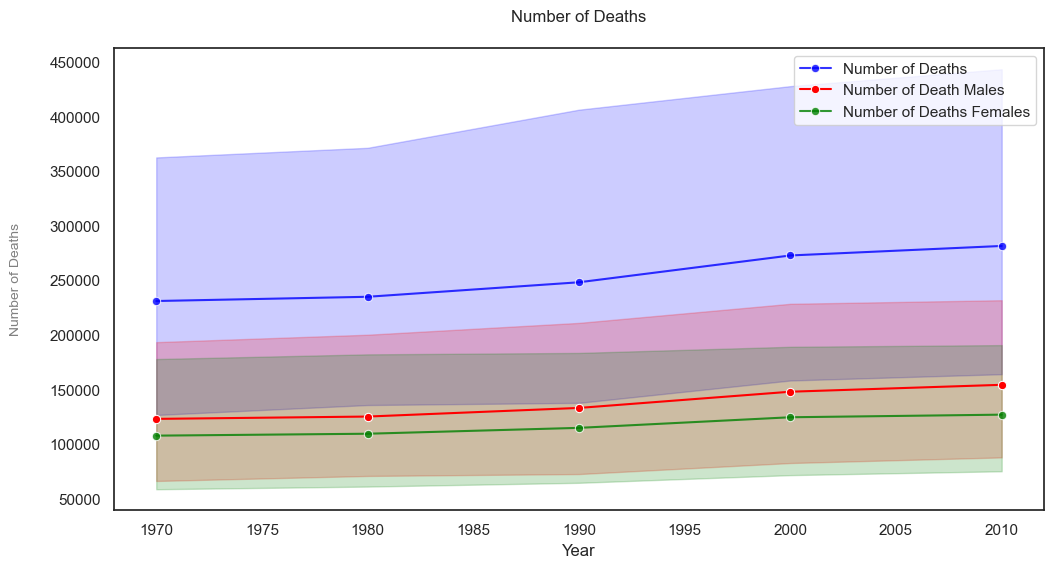

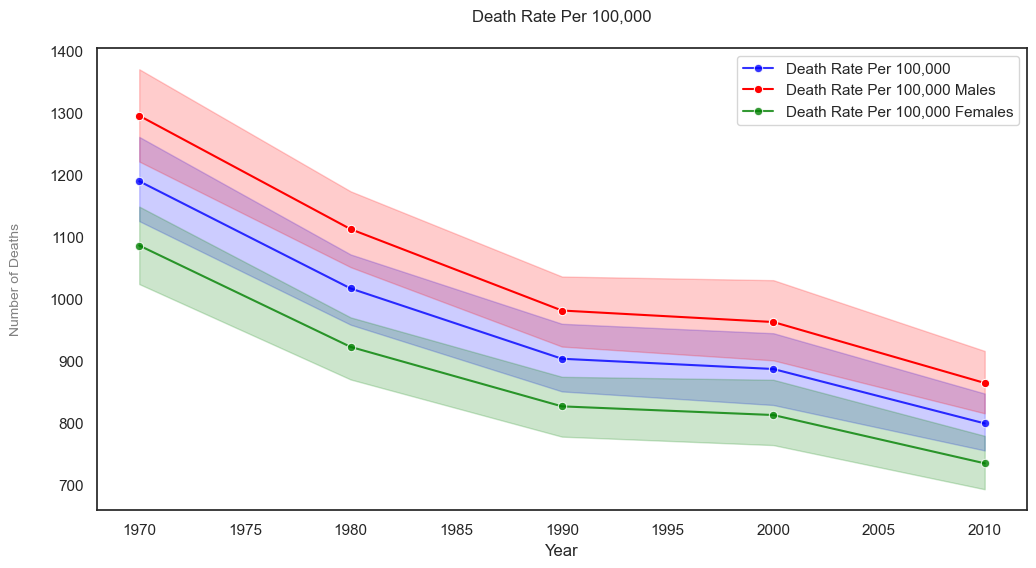

In [22]:
#Number of deaths visualisation:
plt.figure(figsize=(12, 6))
sns.set_theme(style="white", palette=None)
sns.lineplot(x='Year', y='Number of Deaths', data=Global_Burden_of_Disease_df_country, marker='o', color='blue', alpha=0.8, label='Number of Deaths')
sns.lineplot(x='Year', y='Number of Deaths', data=Global_Burden_of_Disease_df_Male, marker='o', label='Number of Death Males', color='red')
sns.lineplot(x='Year', y='Number of Deaths', data=Global_Burden_of_Disease_df_Female, marker='o', color='green', alpha=0.8, label='Number of Deaths Females')


plt.title('Number of Deaths', loc='center', y=1.04) # Remove. Add as subtitle to the presentation instead
#ylabels =  for y in g.get_yticks() / 1000
#g.set_yticks(g.get_yticks())
#g.set_yticklabels(ylabels)
plt.ylabel('Number of Deaths', color='grey', fontsize=10, labelpad=20)
plt.xlabel('Year')

men_vs_women = (Global_Burden_of_Disease_df_Male['Number of Deaths'].sum() - Global_Burden_of_Disease_df_Female['Number of Deaths'].sum()) / Global_Burden_of_Disease_df_Male['Number of Deaths'].sum()
men_vs_women = round(men_vs_women * 100, ndigits=3)
men_vs_women_pct = str(men_vs_women) + '%'
men_vs_women_pct 

print(f'Number of deaths: {men_vs_women_pct} more men died in these years compared to women.')

# Death rate visulisation:
plt.figure(figsize=(12, 6))
sns.set_theme(style="white", palette=None)
sns.lineplot(x='Year', y='Death Rate Per 100,000', data=Global_Burden_of_Disease_df_country, marker='o', color='blue', alpha=0.8, label='Death Rate Per 100,000')
sns.lineplot(x='Year', y='Death Rate Per 100,000', data=Global_Burden_of_Disease_df_Male, marker='o', label='Death Rate Per 100,000 Males', color='red')
sns.lineplot(x='Year', y='Death Rate Per 100,000', data=Global_Burden_of_Disease_df_Female, marker='o', color='green', alpha=0.8, label='Death Rate Per 100,000 Females')



plt.title('Death Rate Per 100,000', loc='center', y=1.04) # Remove. Add as subtitle to the presentation instead
#ylabels =  for y in g.get_yticks() / 1000
#g.set_yticks(g.get_yticks())
#g.set_yticklabels(ylabels)
plt.ylabel('Number of Deaths', color='grey', fontsize=10, labelpad=20)
plt.xlabel('Year')

men_vs_women_rate = (Global_Burden_of_Disease_df_Male['Death Rate Per 100,000'].sum() - Global_Burden_of_Disease_df_Female['Death Rate Per 100,000'].sum()) / Global_Burden_of_Disease_df_Male['Death Rate Per 100,000'].sum()
men_vs_women_rate = round(men_vs_women_rate * 100, ndigits=3)
men_vs_women_pct_rate = str(men_vs_women_rate) + '%'
men_vs_women_pct_rate 

print(f'Death rate per 100,000: {men_vs_women_pct_rate} more men died in these years compared to women.')



##Question: Why is number of death increasing and death rate decreaing. 
#Is this correlation seen within every country.
#Need to look for datasets that can explain this result. Natural distaters in each countries, based on years.
#Already have data for the public health GDP for some countries. 
#Stats to see if the changes in the number of death and death rate has been significant, from 1979 to 2010.

Text(0.5, 0, 'Year')

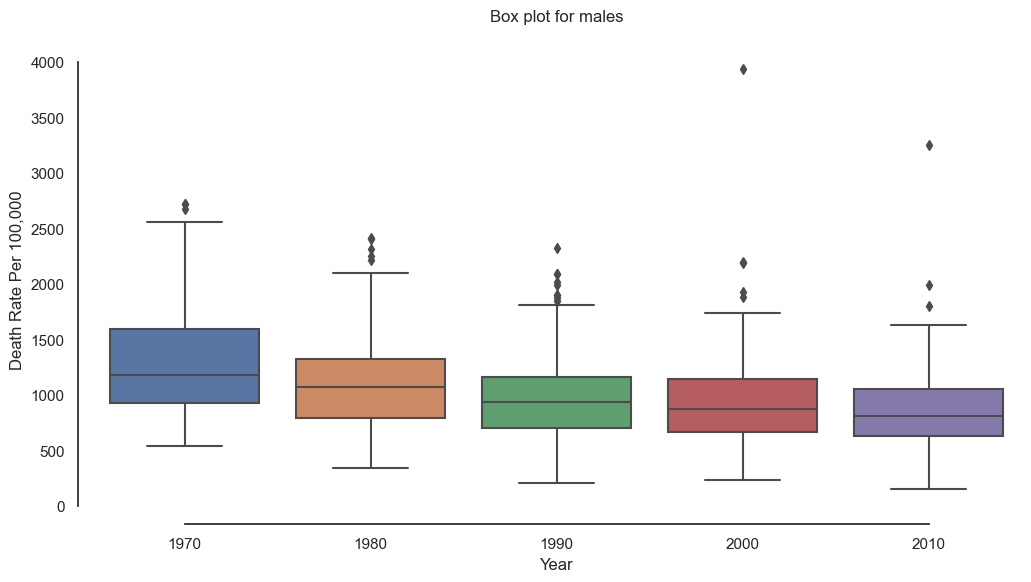

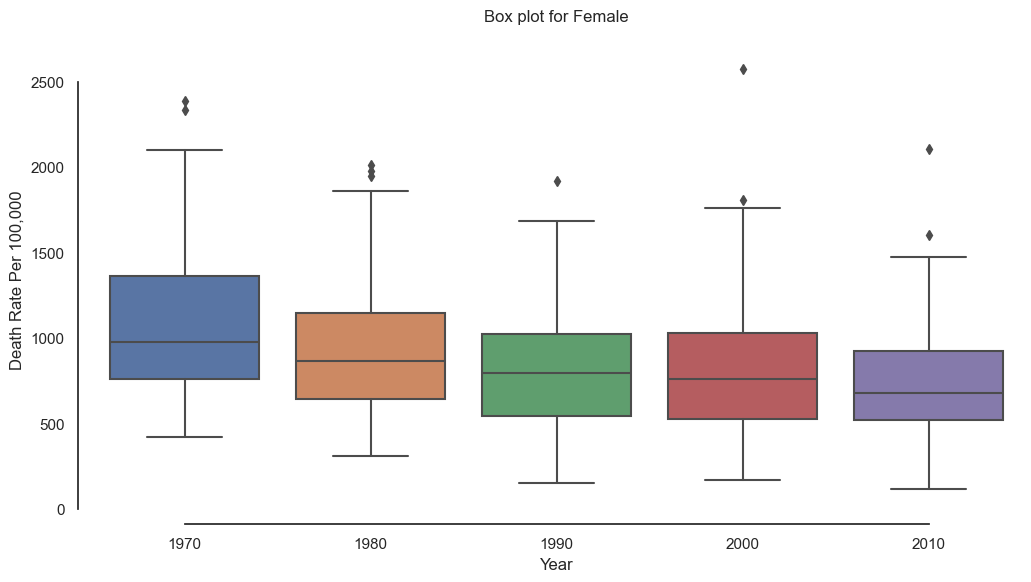

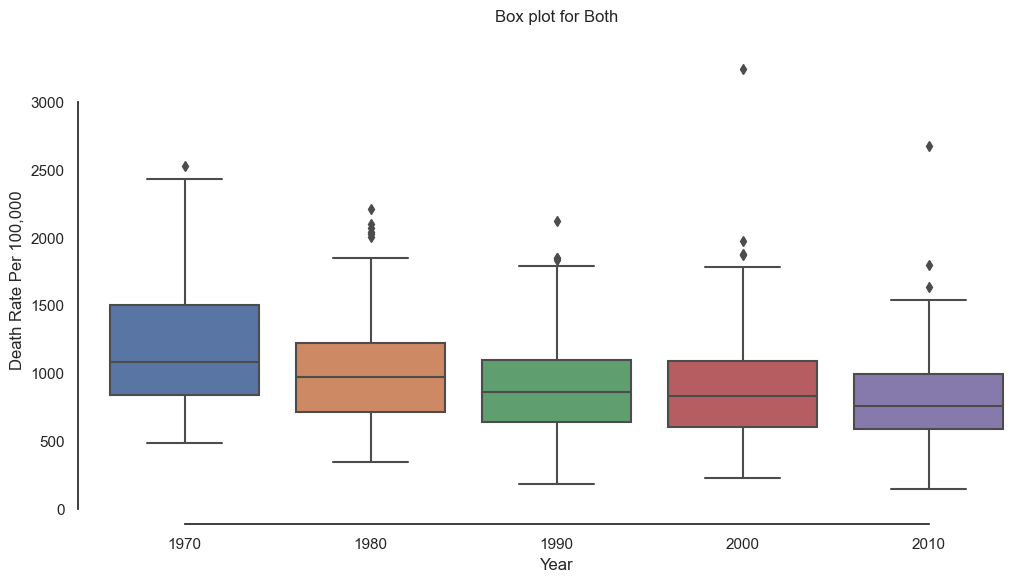

In [23]:
# Check to see if there is an anomally causing death rate result.

# Box plot for male.
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Death Rate Per 100,000',
            data=Global_Burden_of_Disease_df_Male)
sns.despine(offset=10, trim=True)

plt.title('Box plot for males', loc='center', y=1.04) # Remove. Add as subtitle to the presentation instead
#ylabels =  for y in g.get_yticks() / 1000
#g.set_yticks(g.get_yticks())
#g.set_yticklabels(ylabels)
#plt.ylabel()
plt.xlabel('Year')

#Box plot for female:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Death Rate Per 100,000',
            data=Global_Burden_of_Disease_df_Female)
sns.despine(offset=10, trim=True)
plt.title('Box plot for Female', loc='center', y=1.04) # Remove. Add as subtitle to the presentation instead
#ylabels =  for y in g.get_yticks() / 1000
#g.set_yticks(g.get_yticks())
#g.set_yticklabels(ylabels)
#plt.ylabel()
plt.xlabel('Year')

#Box plot for both:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Death Rate Per 100,000',
            data=Global_Burden_of_Disease_df_country)
sns.despine(offset=10, trim=True)
plt.title('Box plot for Both', loc='center', y=1.04) # Remove. Add as subtitle to the presentation instead
#ylabels =  for y in g.get_yticks() / 1000
#g.set_yticks(g.get_yticks())
#g.set_yticklabels(ylabels)
#plt.ylabel()
plt.xlabel('Year')

# Might need to calculate the mean for each dataframe-> i think the result for GBD country is an average based on male and female.

### Number of deaths changes in different countries, in 1970, 1980, 1990, 2000, 2010

In [24]:
cols = ['Number of Deaths', 'Death Rate Per 100,000']
figs = []
frames = []

for c, color in zip(cols, ["Blues", 'Reds']):
    fig = px.choropleth(
        data_frame=Global_Burden_of_Disease_df_country,
        locations='Country Name',
        locationmode='country names',
        color=c,
        hover_name="Country Name",
        animation_frame="Year",
        projection="equirectangular",
        color_continuous_scale=color,
    )
    fig.update_layout(coloraxis_colorbar_title=c)
    figs.append(fig)
    
    for frame in fig.frames:
        frame['name'] = f"{c}_{frame['name']}"
        frames.append(frame)

layout = {
    k: v
    for k, v in figs[0].to_dict()["layout"].items()
    if k not in ["template", "updatemenus"]
}

fig = go.Figure(data=figs[0].data, layout=layout)
fig.frames = frames

frames_dict = {c: [f for f in frames if f['name'].startswith(c)] for c in cols}

dropdown_buttons = [
    {
        "label": c,
        "method": "animate",
        "args": [
            [f"{c}_{year}" for year in Global_Burden_of_Disease_df_country['Year'].unique()],
            {
                "mode": "immediate",
                "frame": {"duration": 500, "redraw": True},
                "transition": {"duration": 0},
            }
        ],
    }
    for c in cols
]

fig.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_buttons,
            "direction": "down",
            "showactive": True,
        }
    ],
    coloraxis_colorbar_title=cols[0],  
    title={"text": f"Choropleth Map - {cols[0]}"}, 
)

fig.show()


In [25]:
decades = [1970, 1980, 1990, 2000, 2010]
cols = ['Number of Deaths', 'Death Rate Per 100,000']
per= ['Number of Deaths pct change', 'Death Rate Per 100,000 pct change']
figs = []
frames = []

for c, color, p in zip(cols, ["Blues", 'Reds'], per):
    fig = px.choropleth(
        data_frame=Global_Burden_of_Disease_df_country,
        locations='Country Name',
        locationmode='country names',
        color=c,
        hover_name="Country Name",
        hover_data=p,
        animation_frame="Year",
        projection="equirectangular",
        color_continuous_scale=color,
    )
    fig.update_layout(coloraxis_colorbar_title=c)
    figs.append(fig)
    
    for frame in fig.frames:
        frame['name'] = f"{c}_{frame['name']}"
        frames.append(frame)

layout = {
    k: v
    for k, v in figs[0].to_dict()["layout"].items()
    if k not in ["template", "updatemenus"]
}

fig = go.Figure(data=figs[0].data, layout=layout)
fig.frames = frames

frames_dict = {c: [f for f in frames if f['name'].startswith(c)] for c in cols}

dropdown_buttons = [
    {
        "label": c,
        "method": "animate",
        "args": [
            [f"{c}_{year}" for year in Global_Burden_of_Disease_df_country['Year'].unique()],
            {
                "mode": "immediate",
                "frame": {"duration": 500, "redraw": True},
                "transition": {"duration": 0},
            }
        ],
    }
    for c in cols
]

fig.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_buttons,
            "direction": "down",
            "showactive": True,
        }
    ],
    coloraxis_colorbar_title=cols[0],  
    title={"text": f"World map of {cols[:]} in {decades}"}, 
)

fig.show()


trial = Global_Burden_of_Disease_df[Global_Burden_of_Disease_df['Country Name'] == 'Nigeria']
trial

In [26]:
#Number of Deaths over a decade

Num_of_deaths = [
    px.choropleth(
        data_frame=Global_Burden_of_Disease_df_country,
        locations='Country Name',
        locationmode='country names',
        color='Number of Deaths',
        title='Number of Deaths over decades',
        hover_name="Country Name",  # identify country code column
        hover_data='Number of Deaths pct change',
        animation_frame="Year",  # identify date column
        projection="equirectangular",  # select projection
        width=1100,
        height=700,
        #color_continuous_scale='Reds',  # select prefer color scale
    )

]


# play / pause don't work as don't stop between columns..
layout = {
    k: v
    for k, v in Num_of_deaths[0].to_dict()["layout"].items()
    if k not in ["template", "updatemenus"]
}


# build figure from all frames, with layout excluding play/pause buttons
Num_of_death_map = go.Figure(
    data=Num_of_deaths[0].data, frames=[fr for f in Num_of_deaths for fr in f.frames], layout=layout
)

# finally build drop down menu...


Num_of_death_map


#### On average number of death increased in every country as shown in the first graph, but this pattern is not seen in every country.

In [27]:
#Death rate over decades

Death_Rate = [
    px.choropleth(
        data_frame=Global_Burden_of_Disease_df_country,
        locations='Country Name',
        locationmode='country names',
        color='Death Rate Per 100,000',
        title='Death Rate Per over decades',
        hover_name="Country Name",  # identify country code column
        hover_data='Death Rate Per 100,000 pct change',
        animation_frame="Year",  # identify date column
        projection="equirectangular",  # select projection
        width=1100,
        height=700,
        color_continuous_scale='Greens',  # select prefer color scale
    )

]


# play / pause don't work as don't stop between columns..
layout = {
    k: v
    for k, v in Death_Rate[0].to_dict()["layout"].items()
    if k not in ["template", "updatemenus"]
}


# build figure from all frames, with layout excluding play/pause buttons
Death_Rate_map = go.Figure(
    data=Death_Rate[0].data, frames=[fr for f in Death_Rate for fr in f.frames], layout=layout
)

# finally build drop down menu...


Death_Rate_map

<Figure size 700x800 with 0 Axes>

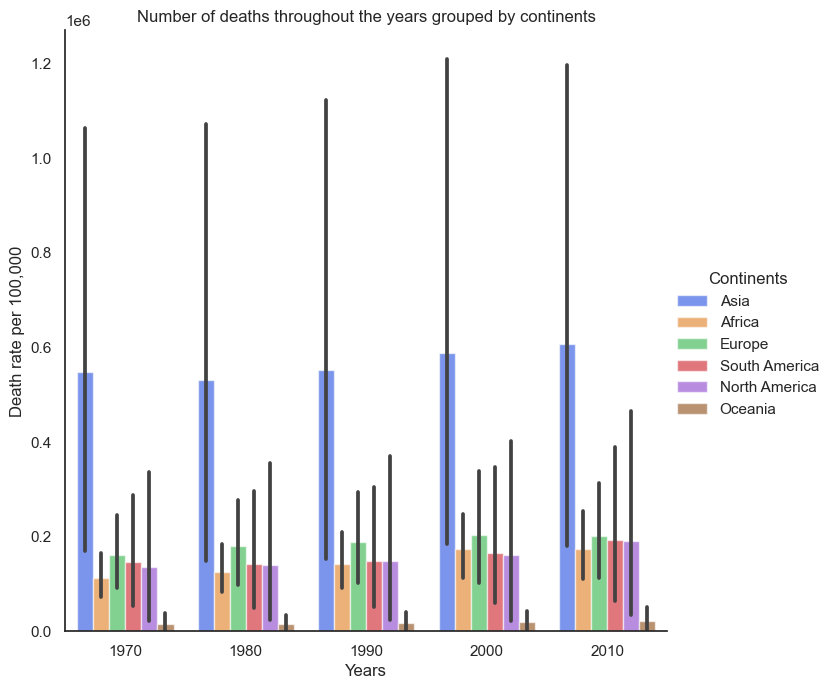

<Figure size 700x800 with 0 Axes>

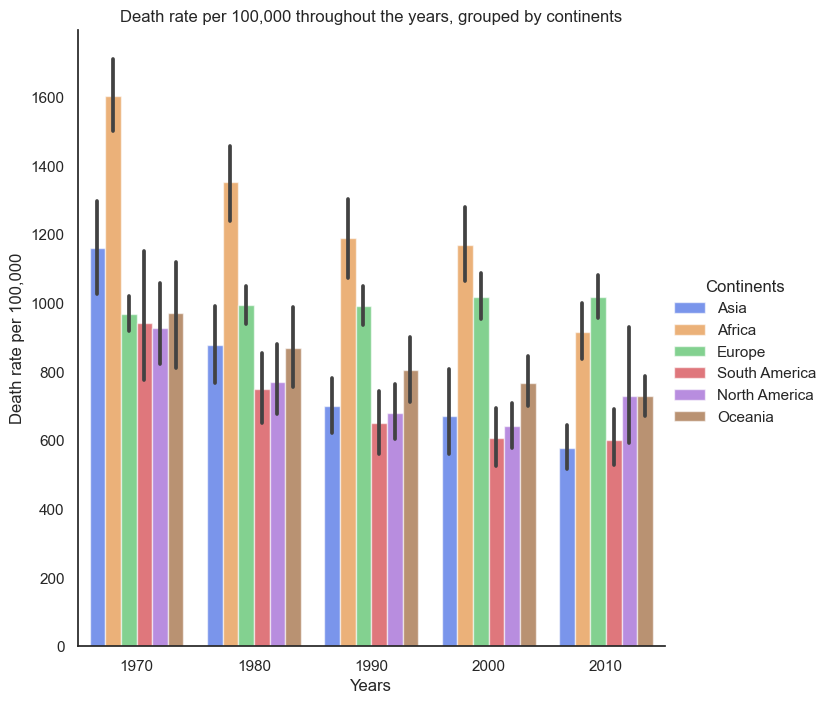

In [28]:
#Number of deaths throughout the years grouped by continents.
plt.figure(figsize=(7, 8))
g = sns.catplot(
    data=Global_Burden_of_Disease_df_country, kind="bar",
    x='Year', y='Number of Deaths', hue="Continents",
    palette="bright", alpha=.6, height=7
)

g.legend.set_title("Continents")

plt.xlabel('Years')
plt.ylabel("Death rate per 100,000")
plt.title('Number of deaths throughout the years grouped by continents', loc='center')

plt.show()

#need to convert left value


#Death rate per 100,000 throughout the years, grouped by continents.
plt.figure(figsize=(7, 8))
g = sns.catplot(
    data=Global_Burden_of_Disease_df_country, kind="bar",
    x='Year', y='Death Rate Per 100,000', hue="Continents",
    palette="bright", alpha=.6, height=7
)
g.legend.set_title("Continents")
plt.xlabel('Years')
plt.ylabel("Death rate per 100,000")
plt.title('Death rate per 100,000 throughout the years, grouped by continents', loc='center')

plt.show()


### Number of Deaths and Death Rate visualisation by age group

<Figure size 1200x1000 with 0 Axes>

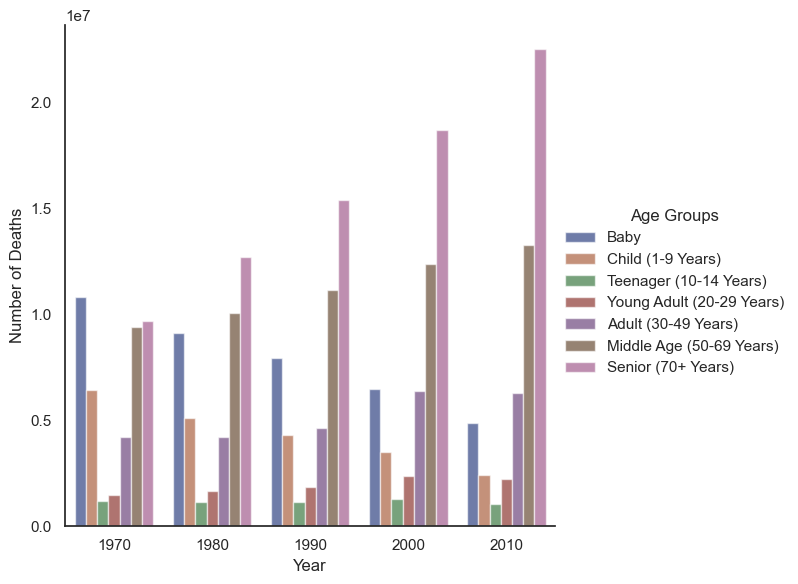

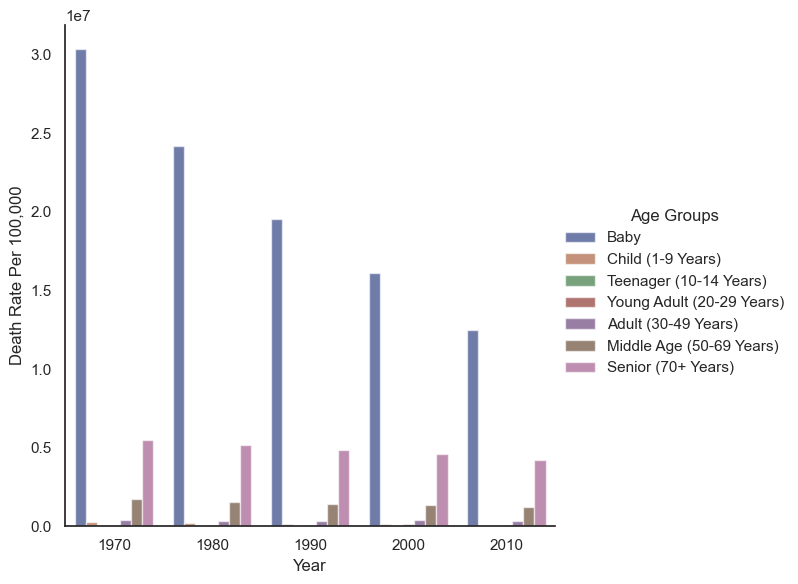

In [29]:
plt.figure(figsize=(12, 10))
#product_counts.plot(kind='bar')

g = sns.catplot(
    data=product_counts, kind="bar",
    x="Year", y="Number of Deaths", hue="Age Groups",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
plt.show()

g = sns.catplot(
    data=product_counts, kind="bar",
    x="Year", y="Death Rate Per 100,000", hue="Age Groups",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
plt.show()



# Why is Number of death increasing? Could this be due to funding?


In [30]:
healthcare_expenditure_vs_gdp_df = pd.read_csv('c:/Users/Asus/Desktop/Juypter Notebook/Data/healthcare-expenditure-vs-gdp.csv')
public_health_expenditure_share_gdp_df = pd.read_csv('c:/Users/Asus/Desktop/Juypter Notebook/Data/public-health-expenditure-share-gdp.csv')
specific_causes_df = pd.read_csv('c:/Users/Asus/Desktop/Juypter Notebook/Data/IHME-GBD_2021_DATA-eb639aed-1.csv')
all_causes_df = pd.read_csv('c:/Users/Asus/Desktop/Juypter Notebook/Data/IHME-GBD_2021_DATA-f3af0dc6-1.csv')

## Need to rename Year column for specific_causes_df, all_causes_df.
specific_causes_df = specific_causes_df.rename(columns={'year':'Year', 'location_name':'Entity'})
all_causes_df = all_causes_df.rename(columns={'year':'Year', 'location_name':'Entity'})
all_causes_df.head(3)



measure_id measure_name  location_id       Entity  sex_id sex_name  age_id  \
0           1       Deaths           19  Timor-Leste       3     Both      22   
1           1       Deaths           19  Timor-Leste       3     Both      22   
2           1       Deaths           19  Timor-Leste       3     Both      22   

   age_name  cause_id  cause_name  metric_id metric_name  Year          val  \
0  All ages       294  All causes          1      Number  1980  9476.659088   
1  All ages       294  All causes          2     Percent  1980     1.000000   
2  All ages       294  All causes          3        Rate  1980  1628.576964   

          upper        lower  
0  10492.548477  8619.673254  
1      1.000000     1.000000  
2   1803.158960  1481.302764

In [31]:
dfs = [public_health_expenditure_share_gdp_df, healthcare_expenditure_vs_gdp_df, specific_causes_df, all_causes_df]
for df in dfs:
    print('------' * 20)
    display(df.head(4))
    print('Shape:',df.shape)
    print('\n')
    print(df.info())

------------------------------------------------------------------------------------------------------------------------


Entity Code  Year  public_health_expenditure_pc_gdp
0  Albania  ALB  2010                             2.442
1  Albania  ALB  2011                             2.387
2  Albania  ALB  2012                             2.474
3  Albania  ALB  2013                             2.605

Shape: (2177, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177 entries, 0 to 2176
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Entity                            2177 non-null   object 
 1   Code                              2177 non-null   object 
 2   Year                              2177 non-null   int64  
 3   public_health_expenditure_pc_gdp  2177 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 68.2+ KB
None
------------------------------------------------------------------------------------------------------------------------


Entity      Code  Year  \
0     Abkhazia  OWID_ABK  2015   
1  Afghanistan       AFG  2002   
2  Afghanistan       AFG  2003   
3  Afghanistan       AFG  2004   

   Current health expenditure per capita, PPP (current international $)  \
0                                                NaN                      
1                                          81.271034                      
2                                          82.457850                      
3                                          89.470055                      

   GDP per capita, PPP (constant 2017 international $)  \
0                                                NaN     
1                                          1280.4631     
2                                          1292.3335     
3                                          1260.0605     

   Population (historical estimates) Continent  
0                                NaN      Asia  
1                         21000258.0       NaN  
2                         22645136.0       NaN  
3                         23553554.0       NaN

Shape: (58556, 7)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58556 entries, 0 to 58555
Data columns (total 7 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Entity                                                                58556 non-null  object 
 1   Code                                                                  55019 non-null  object 
 2   Year                                                                  58556 non-null  int64  
 3   Current health expenditure per capita, PPP (current international $)  4014 non-null   float64
 4   GDP per capita, PPP (constant 2017 international $)                   6346 non-null   float64
 5   Population (historical estimates)                                     58252 non-null  float64
 6   Continent                                                             285 n

measure_id measure_name  location_id       Entity  sex_id sex_name  age_id  \
0           1       Deaths           18     Thailand       3     Both      22   
1           1       Deaths           18     Thailand       3     Both      22   
2           1       Deaths           18     Thailand       3     Both      22   
3           1       Deaths           19  Timor-Leste       3     Both      22   

   age_name  cause_id                                        cause_name  \
0  All ages      1059  Total Cancers excluding Non-melanoma skin cancer   
1  All ages      1059  Total Cancers excluding Non-melanoma skin cancer   
2  All ages      1059  Total Cancers excluding Non-melanoma skin cancer   
3  All ages       300              HIV/AIDS resulting in other diseases   

   metric_id metric_name  Year           val         upper         lower  
0          1      Number  1980  36003.937721  41175.250695  3.053648e+04  
1          2     Percent  1980      0.122637      0.135888  1.054950e-01  
2          3        Rate  1980     77.183525     88.269539  6.546265e+01  
3          1      Number  1980      0.000004      0.000030  5.502090e-07

Shape: (500000, 16)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   measure_id    500000 non-null  int64  
 1   measure_name  500000 non-null  object 
 2   location_id   500000 non-null  int64  
 3   Entity        500000 non-null  object 
 4   sex_id        500000 non-null  int64  
 5   sex_name      500000 non-null  object 
 6   age_id        500000 non-null  int64  
 7   age_name      500000 non-null  object 
 8   cause_id      500000 non-null  int64  
 9   cause_name    500000 non-null  object 
 10  metric_id     500000 non-null  int64  
 11  metric_name   500000 non-null  object 
 12  Year          500000 non-null  int64  
 13  val           500000 non-null  float64
 14  upper         500000 non-null  float64
 15  lower         500000 non-null  float64
dtypes: float64(3), int64(7), object(6)
memory usage: 61.0+ MB
None
-------

measure_id measure_name  location_id       Entity  sex_id sex_name  age_id  \
0           1       Deaths           19  Timor-Leste       3     Both      22   
1           1       Deaths           19  Timor-Leste       3     Both      22   
2           1       Deaths           19  Timor-Leste       3     Both      22   
3           1       Deaths           36   Kazakhstan       3     Both      22   

   age_name  cause_id  cause_name  metric_id metric_name  Year            val  \
0  All ages       294  All causes          1      Number  1980    9476.659088   
1  All ages       294  All causes          2     Percent  1980       1.000000   
2  All ages       294  All causes          3        Rate  1980    1628.576964   
3  All ages       294  All causes          1      Number  1980  116949.131272   

           upper          lower  
0   10492.548477    8619.673254  
1       1.000000       1.000000  
2    1803.158960    1481.302764  
3  121094.949463  113466.536066

Shape: (2448, 16)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   measure_id    2448 non-null   int64  
 1   measure_name  2448 non-null   object 
 2   location_id   2448 non-null   int64  
 3   Entity        2448 non-null   object 
 4   sex_id        2448 non-null   int64  
 5   sex_name      2448 non-null   object 
 6   age_id        2448 non-null   int64  
 7   age_name      2448 non-null   object 
 8   cause_id      2448 non-null   int64  
 9   cause_name    2448 non-null   object 
 10  metric_id     2448 non-null   int64  
 11  metric_name   2448 non-null   object 
 12  Year          2448 non-null   int64  
 13  val           2448 non-null   float64
 14  upper         2448 non-null   float64
 15  lower         2448 non-null   float64
dtypes: float64(3), int64(7), object(6)
memory usage: 306.1+ KB
None


In [32]:
dfs = [public_health_expenditure_share_gdp_df, healthcare_expenditure_vs_gdp_df, specific_causes_df, all_causes_df]
for df in dfs:
    print('------' * 20)
    print('Number of unique Years :', len(df['Year'].unique()))
    print('Number of null values :', df.isnull().sum().sum())
    #display(df['Year'].unique())
    print('Number of unique countries :', len(df['Entity'].unique()))
    #display(df['Entity'].unique())
    
    

------------------------------------------------------------------------------------------------------------------------
Number of unique Years : 68
Number of null values : 0
Number of unique countries : 53
------------------------------------------------------------------------------------------------------------------------
Number of unique Years : 263
Number of null values : 168864
Number of unique countries : 311
------------------------------------------------------------------------------------------------------------------------
Number of unique Years : 4
Number of null values : 0
Number of unique countries : 204
------------------------------------------------------------------------------------------------------------------------
Number of unique Years : 4
Number of null values : 0
Number of unique countries : 204


# Cleaning new data frames

### Cleaning the dataset healthcare_expenditure_vs_gdp_df
#### healthcare_expenditure_vs_gdp_df used to identify relationship between population/gdp per capita and number of deaths.

In [33]:
healthcare_expenditure_vs_gdp_df_cleaning = healthcare_expenditure_vs_gdp_df.copy() 

#Filter years

required_years = [1970, 1980, 1990, 2000, 2010]

def same_years(df):
    desired_years = df[df['Year'].isin(required_years)]
    sort_df = desired_years.sort_values(['Entity', 'Year'])
    return sort_df

healthcare_expenditure_vs_gdp_df_cleaning = same_years(healthcare_expenditure_vs_gdp_df_cleaning)

#Remove uneccessary columns.
#Need to filter Entity, so it is the same as global burden of disease.
#Filter countries using the country code from global burden disease.
#Remove null values.
#number of deaths correlate with increasing population.

healthcare_expenditure_vs_gdp_df_cleaning = healthcare_expenditure_vs_gdp_df_cleaning.drop(['Continent'], axis=1)
healthcare_expenditure_vs_gdp_df_cleaning

#Filtering healthcare expenditure vs gdp dataframe, so iut has the same countrues as global burden of diseases.
#Rename columns

list_of_country_codes= []
for code in Global_Burden_of_Disease_df_country['Country Code']:
    list_of_country_codes.append(code)
list_of_country_codes = list(set(list_of_country_codes))
list_of_country_codes
code_mask = healthcare_expenditure_vs_gdp_df_cleaning['Code'].isin(list_of_country_codes)
healthcare_expenditure_vs_gdp_df_cleaning = healthcare_expenditure_vs_gdp_df_cleaning[code_mask]
healthcare_expenditure_vs_gdp_df_cleaning = healthcare_expenditure_vs_gdp_df_cleaning.rename(columns={'Entity':'Country_name', 'Code':'Country_code'})
healthcare_expenditure_vs_gdp_df_cleaning.head(3)



Country_name Country_code  Year  \
228  Afghanistan          AFG  1970   
238  Afghanistan          AFG  1980   
248  Afghanistan          AFG  1990   

     Current health expenditure per capita, PPP (current international $)  \
228                                                NaN                      
238                                                NaN                      
248                                                NaN                      

     GDP per capita, PPP (constant 2017 international $)  \
228                                                NaN     
238                                                NaN     
248                                                NaN     

     Population (historical estimates)  
228                         10752973.0  
238                         12486640.0  
248                         10694804.0

In [34]:
def convert_to_million(x):
    million = x / 1000000
    return million


k = list(Global_Burden_of_Disease_df_country['Country Name'].unique())
country_names_change = healthcare_expenditure_vs_gdp_df_cleaning[~healthcare_expenditure_vs_gdp_df_cleaning['Country_name'].isin(k)]
country_names_change

country_changes = {
    "Cote d'Ivoire": 'Ivory Coast',
    'Democratic Republic of Congo': 'Democratic Republic of the Congo',
    'Congo': 'Republic of the Congo',
    'Micronesia (country)': 'Micronesia',
    'Eswatini': 'Swaziland',
    'Czechia': 'Czech Republic'
}

healthcare_expenditure_vs_gdp_df_cleaning['Country_name'] = healthcare_expenditure_vs_gdp_df_cleaning['Country_name'].replace(country_changes)

#'Congo', "Cote d'Ivoire", 'Czechia','Democratic Republic of Congo', 'Eswatini', 'Micronesia (country)'






In [35]:
# Merge global burden of disease dataframe and healthcare_expenditure_vs_gdp_df


healthcare_expenditure_global_burden_df = pd.merge(Global_Burden_of_Disease_df_country, healthcare_expenditure_vs_gdp_df_cleaning,  how='left', left_on=['Year','Country Name', 'Country Code'], right_on = ['Year','Country_name', 'Country_code'])



#remove columns that are not needed:
healthcare_expenditure_global_burden_df = healthcare_expenditure_global_burden_df.drop(columns=['Number of Deaths pct change', 'Death Rate Per 100,000 pct change', 'Age Group', 'Sex', 'Country_name', 'Country_code'])
#rename column
healthcare_expenditure_global_burden_df = healthcare_expenditure_global_burden_df.rename(columns={'Number of Deaths':'Number of Deaths (Million)', 'Population (historical estimates)':'Population (Million)', 'Current health expenditure per capita, PPP (current international $)':'Health expenditure per capita(current international $)', 'GDP per capita, PPP (constant 2017 international $)': 'GDP per capita (constant 2017 international $)'})
healthcare_expenditure_global_burden_df.describe()

healthcare_expenditure_global_burden_df['Number of Deaths (Million)'] = healthcare_expenditure_global_burden_df['Number of Deaths (Million)'].apply(convert_to_million)
healthcare_expenditure_global_burden_df['Population (Million)'] = healthcare_expenditure_global_burden_df['Population (Million)'].apply(convert_to_million)
healthcare_expenditure_global_burden_df.columns

#Natural expecation for number of death to increase as population increase. 
#Graph displaying this  and stating the above do a seaborn graph instead.





Index(['Country Code', 'Country Name', 'Year', 'Number of Deaths (Million)',
       'Death Rate Per 100,000', 'Continents',
       'Health expenditure per capita(current international $)',
       'GDP per capita (constant 2017 international $)',
       'Population (Million)'],
      dtype='object')

### Try to visualise number of disease and population

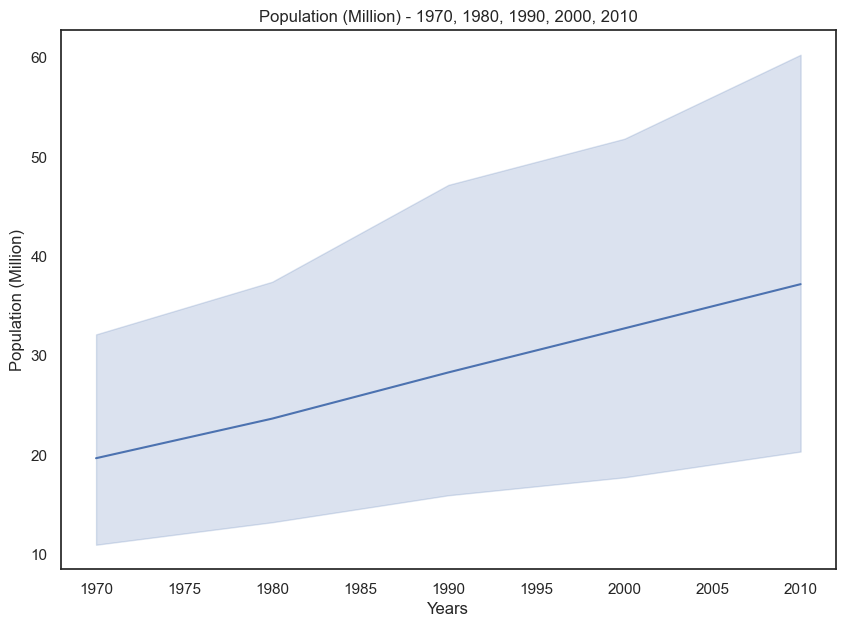

<Figure size 700x1000 with 0 Axes>

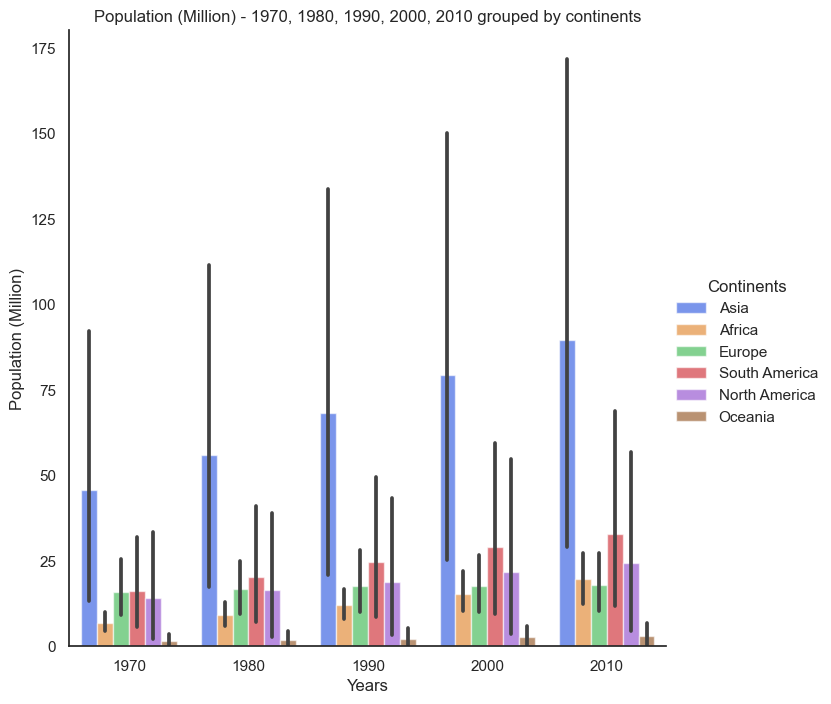

In [36]:
#Population (Million) - 1970, 1980, 1990, 2000, 2010
plt.figure(figsize=(10, 7))
sns.lineplot(x="Year", y="Population (Million)", data=healthcare_expenditure_global_burden_df)

plt.xlabel('Years')
plt.ylabel('Population (Million)')
plt.title('Population (Million) - 1970, 1980, 1990, 2000, 2010', loc='center')

plt.show()



#Population (Million) - 1970, 1980, 1990, 2000, 2010 grouped by continents
plt.figure(figsize=(7, 10))
g = sns.catplot(
    data=healthcare_expenditure_global_burden_df, kind="bar",
    x='Year', y='Population (Million)', hue="Continents",
    palette="bright", alpha=.6, height=7
)

plt.xlabel('Years')
plt.ylabel('Population (Million)')
plt.title('Population (Million) - 1970, 1980, 1990, 2000, 2010 grouped by continents', loc='center')

plt.show()


### Based on the above graph, population has been increasing throughout the years.
### What the highest/lowest value based in country?
### Which population increases the most-> percentage change

<Figure size 600x600 with 0 Axes>

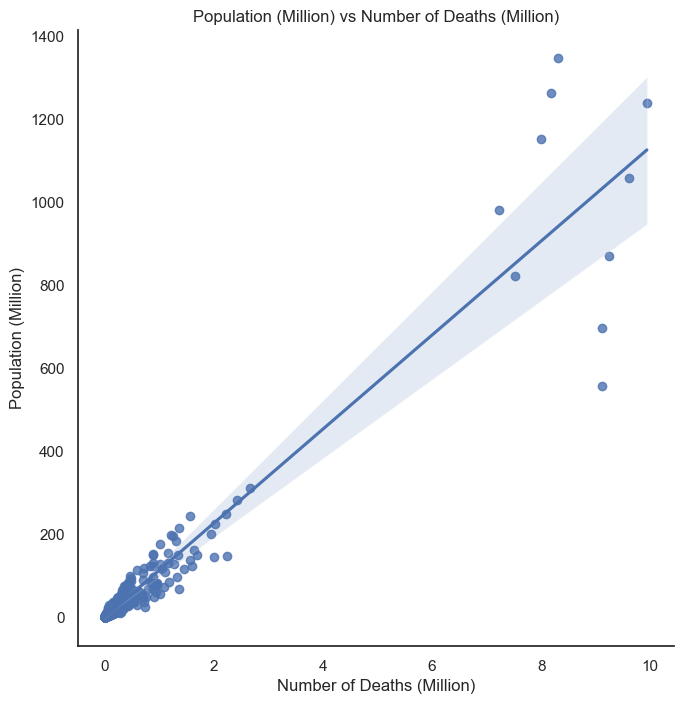

PearsonRResult(statistic=0.9594703457015908, pvalue=0.0)


<Figure size 600x600 with 0 Axes>

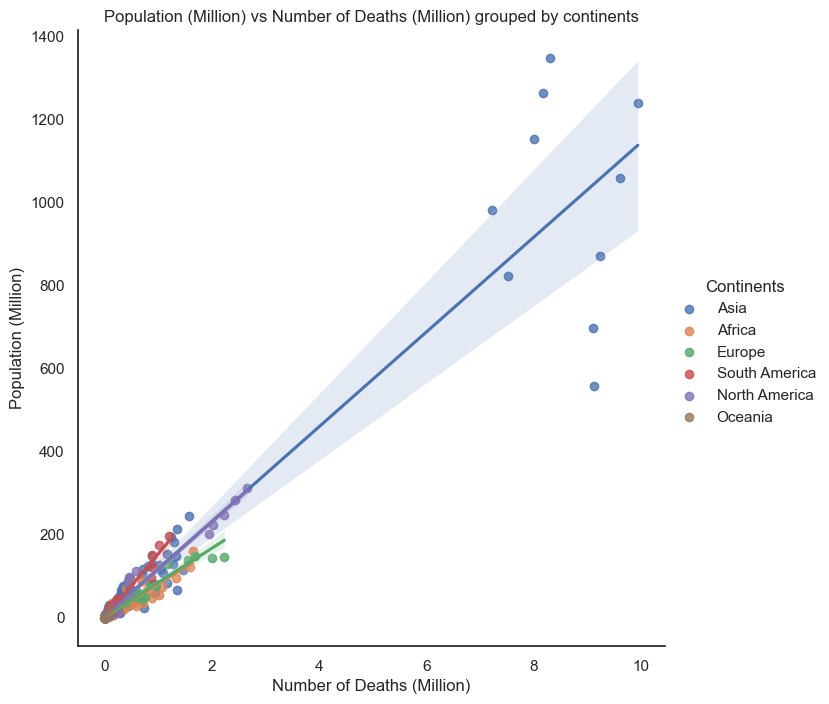

In [37]:
#Is there a correlation between population and number of deaths.
plt.figure(figsize=(6, 6))
g = sns.lmplot(
    data=healthcare_expenditure_global_burden_df,
    x="Number of Deaths (Million)", y="Population (Million)",
    height=7,
)


#plt.xlabel('Years')
#plt.ylabel('Number of Deaths (Million)')
plt.title('Population (Million) vs Number of Deaths (Million)', loc='center')

plt.show()


print(pearsonr(healthcare_expenditure_global_burden_df['Population (Million)'], healthcare_expenditure_global_burden_df['Number of Deaths (Million)']))


#Is this correlation present when the data is grouped by continents.
plt.figure(figsize=(6, 6))
g = sns.lmplot(
    data=healthcare_expenditure_global_burden_df,
    x="Number of Deaths (Million)", y="Population (Million)", hue="Continents",
    height=7,
)

#plt.xlabel('Years')
#plt.ylabel('Number of Deaths (Million)')
plt.title('Population (Million) vs Number of Deaths (Million) grouped by continents', loc='center')

plt.show()


### Based on the above graph, there is a positive correlation between Number of deaths and population, this is further proven by the pearson correlation score.
### As population increase so does number of death in eavery year.

In [38]:

#I decided to remove null values from the Population (Million) column because, based on my judgemnet the removal of these values do not affect the overall result.
#The null values I removed are 

print(pearsonr(healthcare_expenditure_global_burden_df['Population (Million)'], healthcare_expenditure_global_burden_df['Number of Deaths (Million)']))

#healthcare_expenditure_global_burden_df['Number of Deaths (Million)'].isna()


PearsonRResult(statistic=0.9594703457015908, pvalue=0.0)


### Number of deaths and GDP per capita

In [39]:
### Aim: Does GDP affect the number of death.

### cleaning the dataframe for GDP per capita
### Trying to visualise the GDP per capita and number of deaths

In [40]:
GDP_vs_num_of_deaths = healthcare_expenditure_global_burden_df.copy()
#Filter datframe columns= country name, number of deaths, GDP per capita
GDP_vs_num_of_deaths = GDP_vs_num_of_deaths.filter(['Country Name','Continents', 'Year', 'Number of Deaths (Million)', 'Death Rate Per 100,000', 'GDP per capita (constant 2017 international $)'])
#Remove null values. I don't think I should fill in null values, because I think it would skew the result.
GDP_vs_num_of_deaths = GDP_vs_num_of_deaths[GDP_vs_num_of_deaths['GDP per capita (constant 2017 international $)'].notnull()]
#Identify Years that will be used for this analysis.
GDP_vs_num_of_deaths['Year'].describe()
#Filter dataframe, so countries with 3 years are present-> 1990, 2000, 2010.
v = GDP_vs_num_of_deaths['Country Name'].value_counts()
GDP_vs_num_of_deaths = GDP_vs_num_of_deaths[GDP_vs_num_of_deaths['Country Name'].isin(v.index[v.gt(2)])]

GDP_vs_num_of_deaths.head(3)



Country Name Continents  Year  Number of Deaths (Million)  \
7       Angola     Africa  1990                    0.191100   
8       Angola     Africa  2000                    0.201736   
9       Angola     Africa  2010                    0.161489   

   Death Rate Per 100,000  GDP per capita (constant 2017 international $)  
7                  1830.7                                       5768.5645  
8                  1433.1                                       4708.3610  
9                   835.7                                       7691.1313

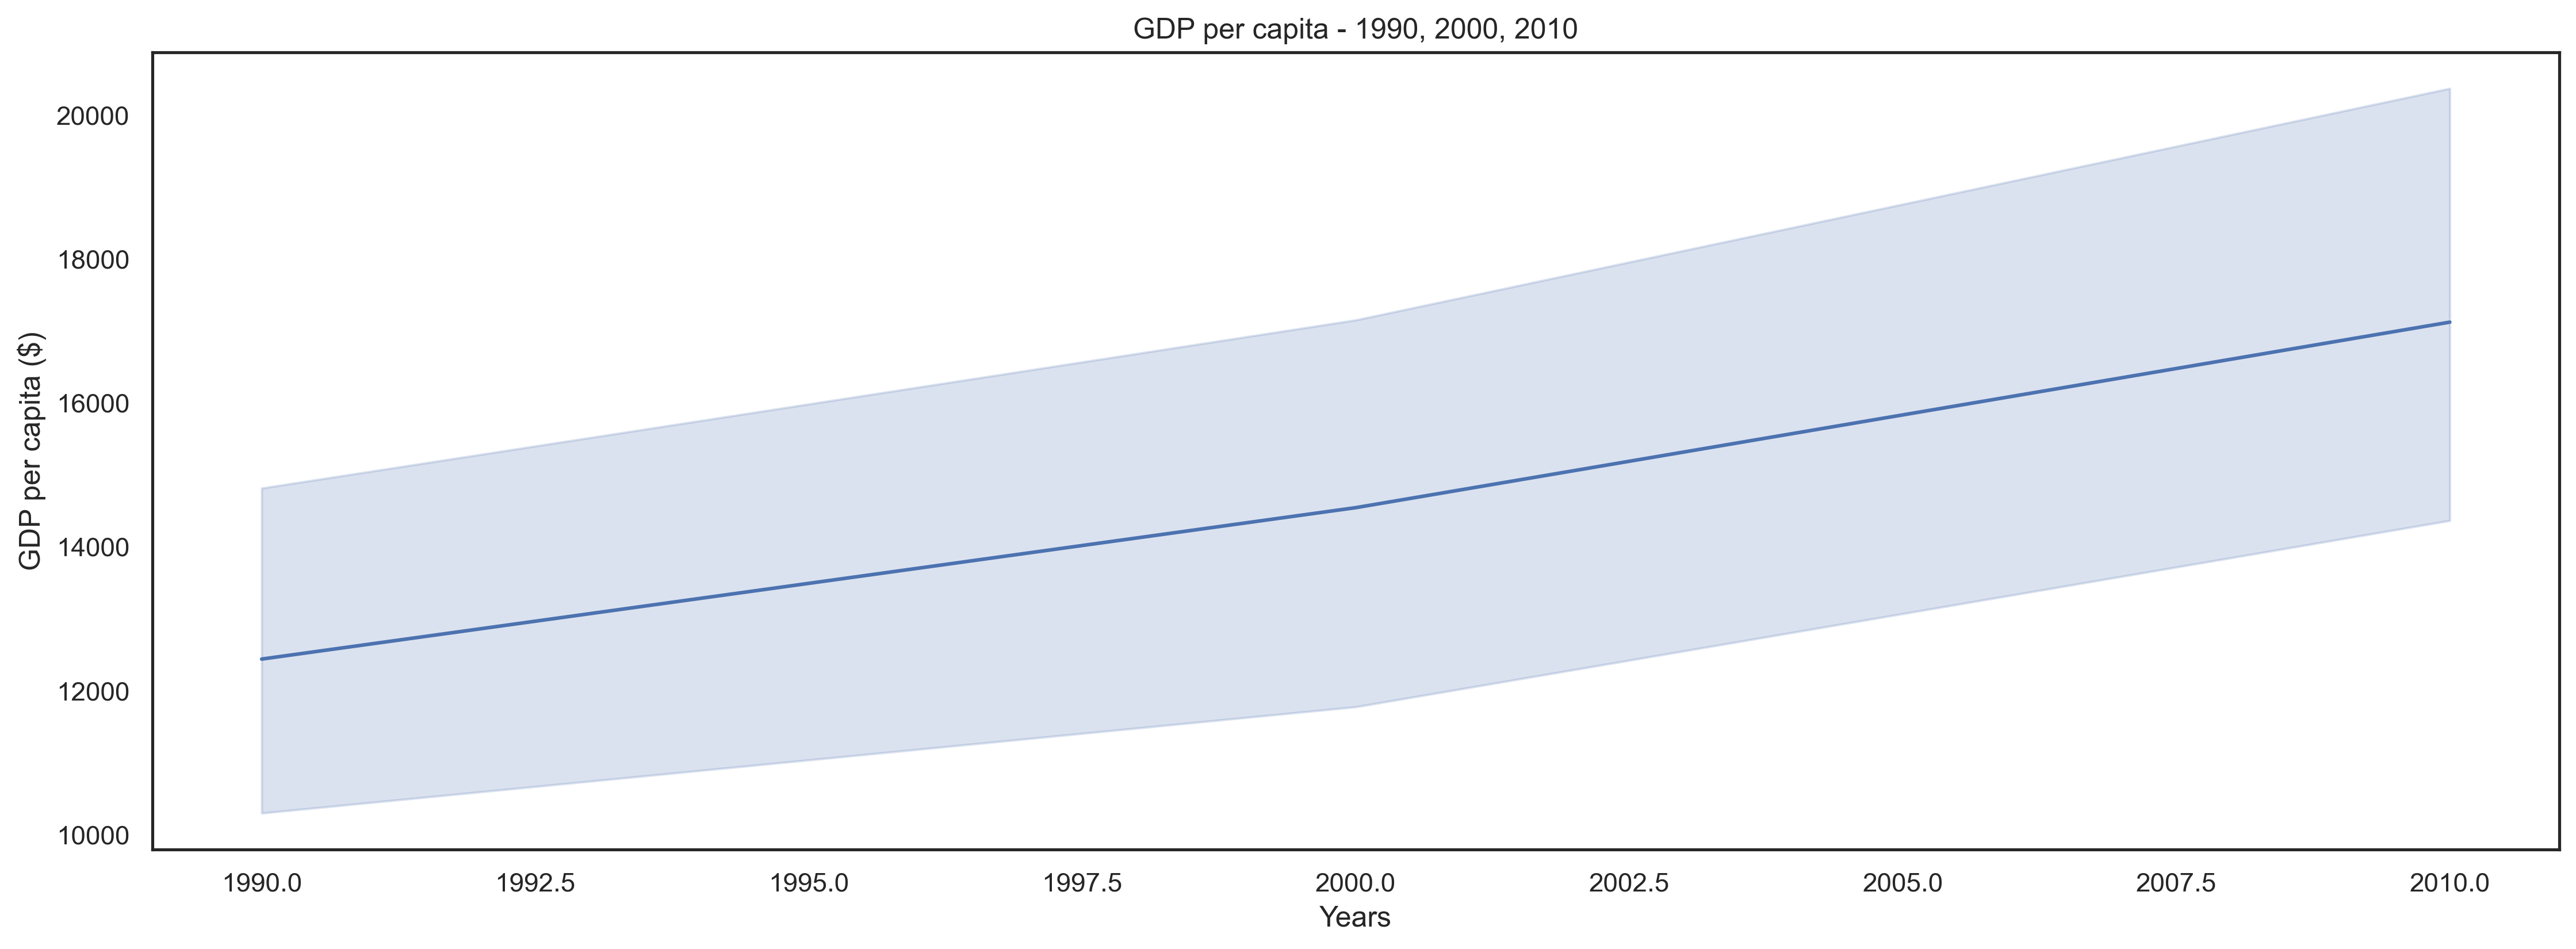

<Figure size 700x1000 with 0 Axes>

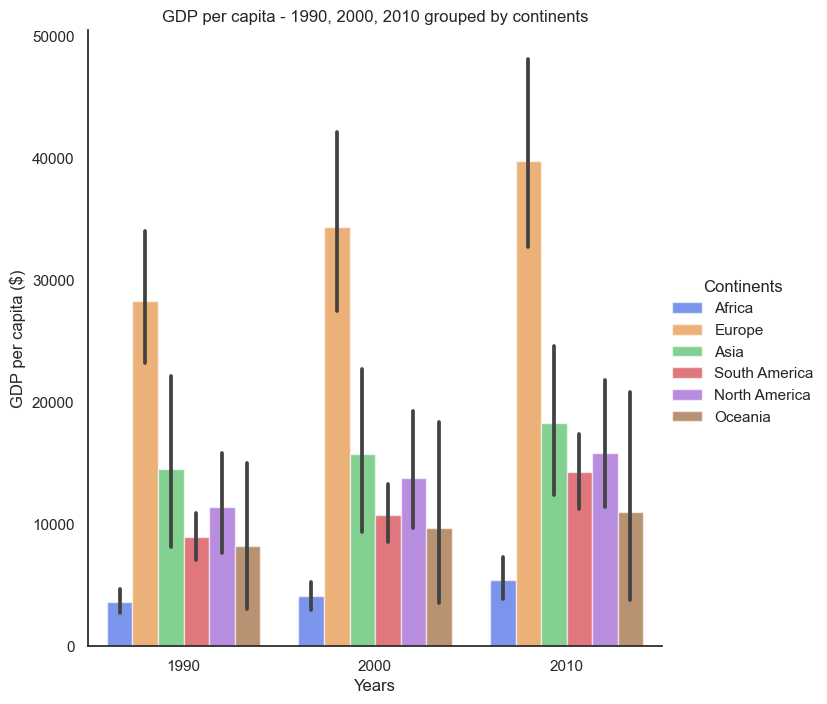

In [41]:
#Converting GPD to million. 
#GDP_vs_num_of_deaths['GDP per capita (constant 2017 international $)'] = GDP_vs_num_of_deaths['GDP per capita (constant 2017 international $)'].apply(convert_to_million)

#Make a visualisation comp[aring the changes of GDP and Number of death throughout the years.

#sns.lineplot(x='Year', y='GDP per capita (constant 2017 international $)', data=GDP_vs_num_of_deaths, color='blue', alpha=0.8, label='Death Rate Per 100,000')
#.lineplot(x='Year', y='Number of Deaths (Million)', data=GDP_vs_num_of_deaths, color='red', alpha=0.8, label='Death Rate Per 100,000 Males')


GDP_vs_num_of_deaths

#GDP per capita - 1990, 2000, 2010
fig, axs = plt.subplots(ncols=1, sharey=True, figsize=(18, 6), dpi=300)

sns.lineplot(x="Year", y="GDP per capita (constant 2017 international $)", data=GDP_vs_num_of_deaths)

plt.xlabel('Years')
plt.ylabel('GDP per capita ($)')
plt.title('GDP per capita - 1990, 2000, 2010', loc='center')

plt.show()

#GDP per capita - 1990, 2000, 2010 grouped by continents
plt.figure(figsize=(7, 10))
g = sns.catplot(
    data=GDP_vs_num_of_deaths, kind="bar",
    x='Year', y='GDP per capita (constant 2017 international $)', hue="Continents",
    palette="bright", alpha=.6, height=7
)
plt.xlabel('Years')
plt.ylabel('GDP per capita ($)')
plt.title('GDP per capita - 1990, 2000, 2010 grouped by continents', loc='center')

plt.show()


<Figure size 600x600 with 0 Axes>

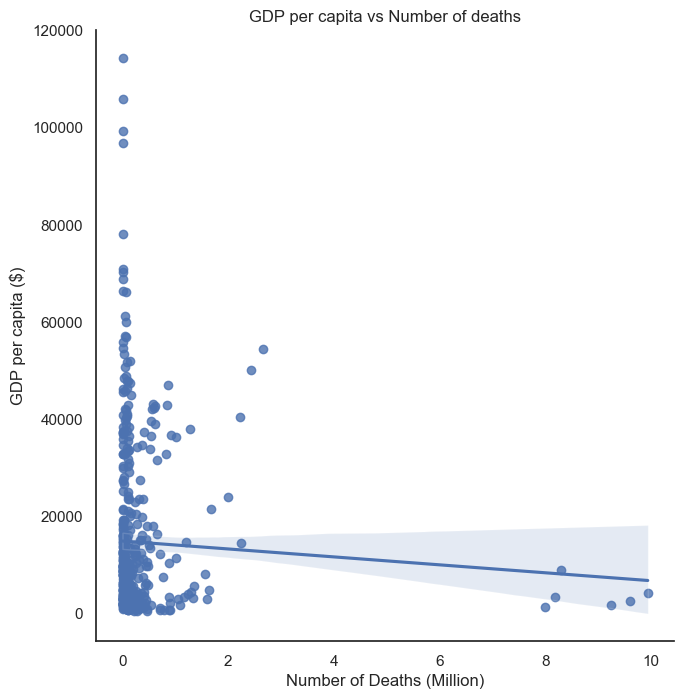

PearsonRResult(statistic=-0.04896476268010751, pvalue=0.2951906299640057)


<Figure size 600x600 with 0 Axes>

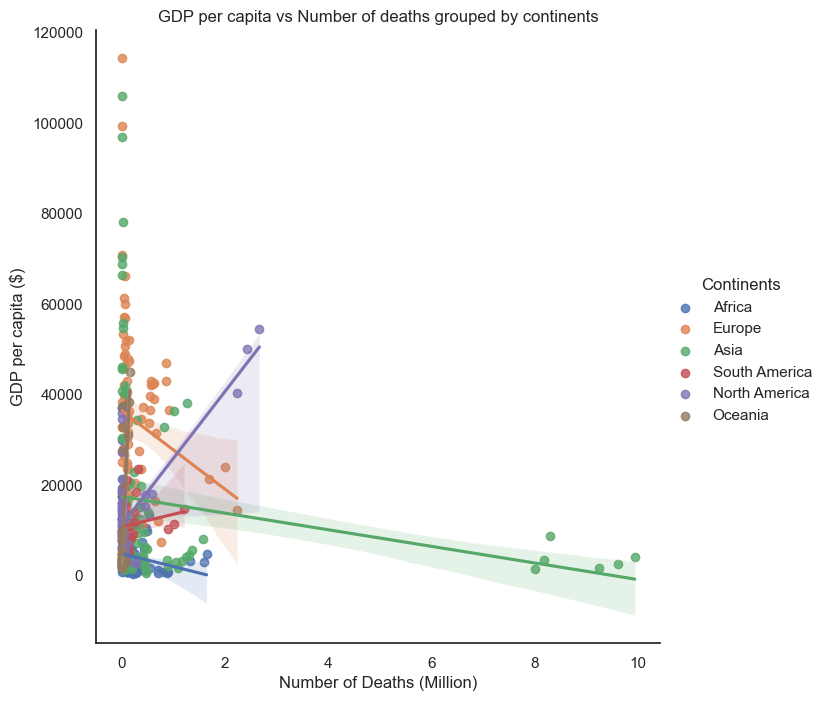

PearsonRResult(statistic=-0.04896476268010751, pvalue=0.2951906299640057)


In [42]:
#GDP per capita vs Number of deaths
plt.figure(figsize=(6, 6))
g = sns.lmplot(
    data=GDP_vs_num_of_deaths,
    x="Number of Deaths (Million)", y="GDP per capita (constant 2017 international $)",
    height=7
)

plt.xlabel('Number of Deaths (Million)')
plt.ylabel('GDP per capita ($)')
plt.title('GDP per capita vs Number of deaths', loc='center')

plt.show()

print(pearsonr(GDP_vs_num_of_deaths['GDP per capita (constant 2017 international $)'], GDP_vs_num_of_deaths['Number of Deaths (Million)']))

#GDP per capita vs Number of deaths grouped by continents
plt.figure(figsize=(6, 6))
g = sns.lmplot(
    data=GDP_vs_num_of_deaths,
    x="Number of Deaths (Million)", y='GDP per capita (constant 2017 international $)', hue='Continents',
    height=7,
)

plt.xlabel('Number of Deaths (Million)')
plt.ylabel('GDP per capita ($)')
plt.title('GDP per capita vs Number of deaths grouped by continents', loc='center')

plt.show()
print(pearsonr(GDP_vs_num_of_deaths['Number of Deaths (Million)'], GDP_vs_num_of_deaths['GDP per capita (constant 2017 international $)']))


### What is GDP ? Some countries have low GDP and low number of deaths and vice versa.

## public_health_expenditure_share_gdp_df

### Cleaning dataframe

In [43]:
#Filter years
#Remove countries that only have one year.
public_health_expenditure_share_gdp_df_cleaning = public_health_expenditure_share_gdp_df.copy() 
public_health_expenditure_share_gdp_df_cleaning= same_years(public_health_expenditure_share_gdp_df_cleaning)
public_health_expenditure_share_gdp_df_cleaning = public_health_expenditure_share_gdp_df_cleaning.rename(columns={'Entity':'Country_name', 'Code':'Country_code'})
public_health_expenditure_share_gdp_df_cleaning


v = public_health_expenditure_share_gdp_df_cleaning['Country_name'].value_counts()
public_health_expenditure_share_gdp_df_cleaned = public_health_expenditure_share_gdp_df_cleaning[public_health_expenditure_share_gdp_df_cleaning['Country_name'].isin(v.index[v.gt(4)])]
public_health_expenditure_share_gdp_df_cleaned.head(3)





Country_name Country_code  Year  public_health_expenditure_pc_gdp
45    Australia          AUS  1970                          2.622135
55    Australia          AUS  1980                          3.662000
65    Australia          AUS  1990                          4.281000

### Trying to visualise Number of deaths and public health expenditure

In [44]:
public_health_expenditure_share_gdp_df_cleaned.head(3)

Country_name Country_code  Year  public_health_expenditure_pc_gdp
45    Australia          AUS  1970                          2.622135
55    Australia          AUS  1980                          3.662000
65    Australia          AUS  1990                          4.281000

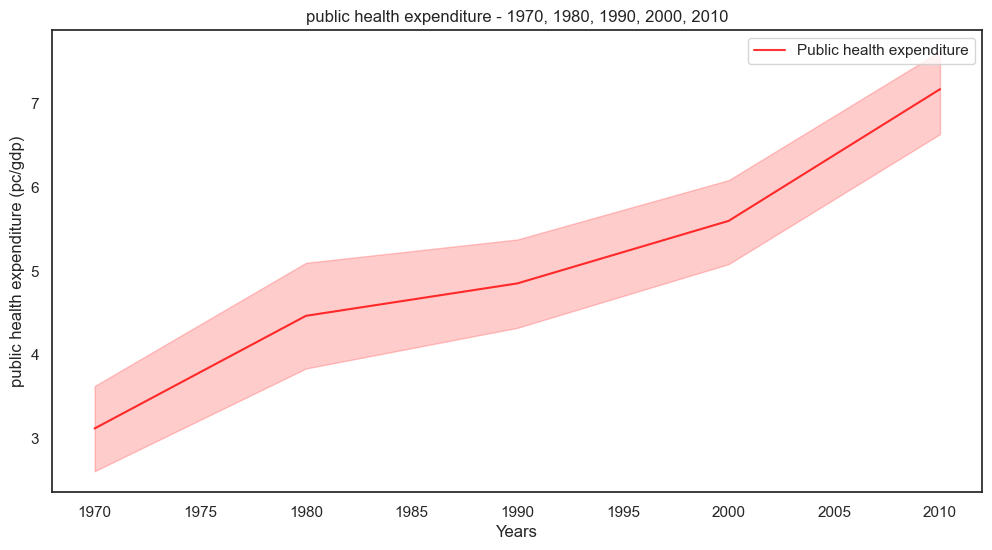

<Figure size 700x1000 with 0 Axes>

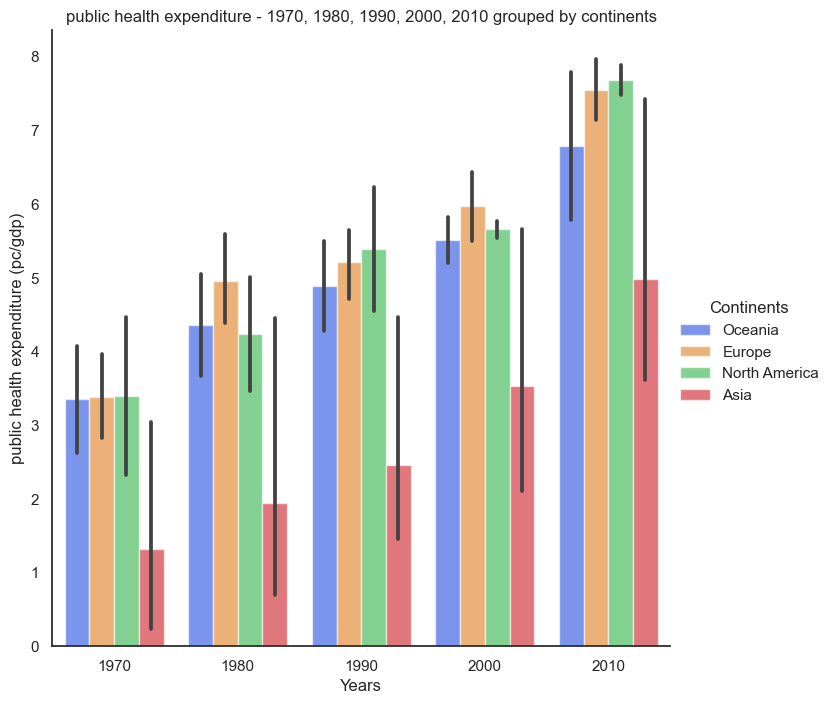

In [45]:
#Create a dataframe from global burden of disease that has the same countries as public health dataframe 
list_of_countries= []
for country in public_health_expenditure_share_gdp_df_cleaned['Country_name']:
    list_of_countries.append(country)
list_of_countries = list(set(list_of_countries))
list_of_countries

Global_Burden_of_Disease_df_country_public_health = Global_Burden_of_Disease_df_country.copy()
country_mask = Global_Burden_of_Disease_df_country_public_health['Country Name'].isin(list_of_countries)
Global_Burden_of_Disease_df_country_public_health = Global_Burden_of_Disease_df_country_public_health[country_mask]
Global_Burden_of_Disease_df_country_public_health

#merging dataframes
GBD_public_health_df = pd.merge(Global_Burden_of_Disease_df_country_public_health, public_health_expenditure_share_gdp_df_cleaned,  how='left', left_on=['Year','Country Name', 'Country Code'], right_on = ['Year','Country_name', 'Country_code'])

#Cleaning dataframe
GBD_public_health_df = GBD_public_health_df.drop(columns=['Country Code', 'Country_name', 'Country_code'])
GBD_public_health_df

#Convert values to million
GBD_public_health_df['Number of Deaths'] = GBD_public_health_df['Number of Deaths'].apply(convert_to_million)


#Need to make a visualisation using public health data frame and global burden of disease public heath dataframe
# Graph will be use to see if there is a correlation between number of disease and public health.
#Also need to do stats calculation.

#public health expenditure - 1970, 1980, 1990, 2000, 2010
plt.figure(figsize=(12, 6))
sns.set_theme(style="white", palette=None)
sns.lineplot(x='Year', y='public_health_expenditure_pc_gdp', data=public_health_expenditure_share_gdp_df_cleaned, color='red', alpha=0.8, label='Public health expenditure')

plt.ylabel('public health expenditure (pc/gdp)')
plt.xlabel('Years')
plt.title('public health expenditure - 1970, 1980, 1990, 2000, 2010', loc='center')

plt.show()

#public health expenditure - 1970, 1980, 1990, 2000, 2010 grouped by continenets
plt.figure(figsize=(7, 10))
g = sns.catplot(
    data=GBD_public_health_df, kind="bar",
    x='Year', y='public_health_expenditure_pc_gdp', hue="Continents",
    palette="bright", alpha=.6, height=7
)

plt.ylabel('public health expenditure (pc/gdp)')
plt.xlabel('Years')
plt.title('public health expenditure - 1970, 1980, 1990, 2000, 2010 grouped by continents', loc='center')

plt.show()




<Figure size 1200x600 with 0 Axes>

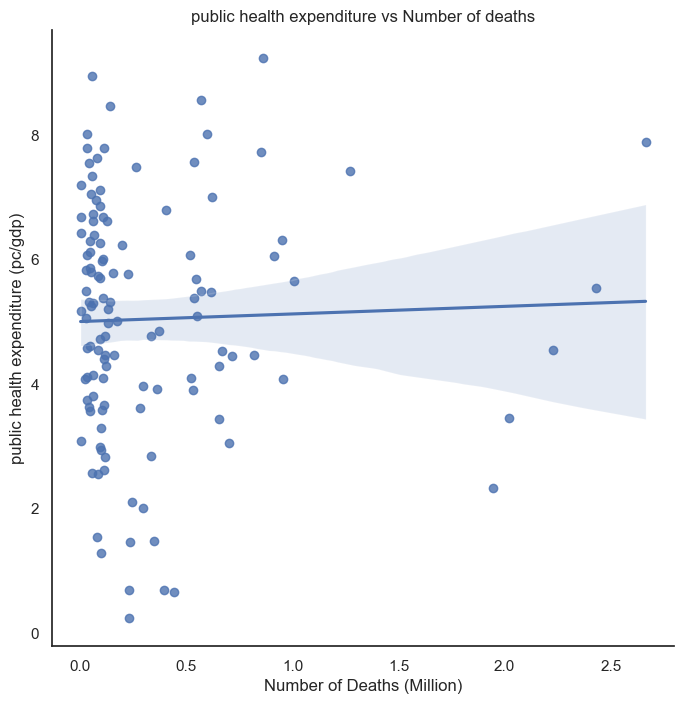

PearsonRResult(statistic=0.030932625779898207, pvalue=0.7373358156455231)


<Figure size 1200x600 with 0 Axes>

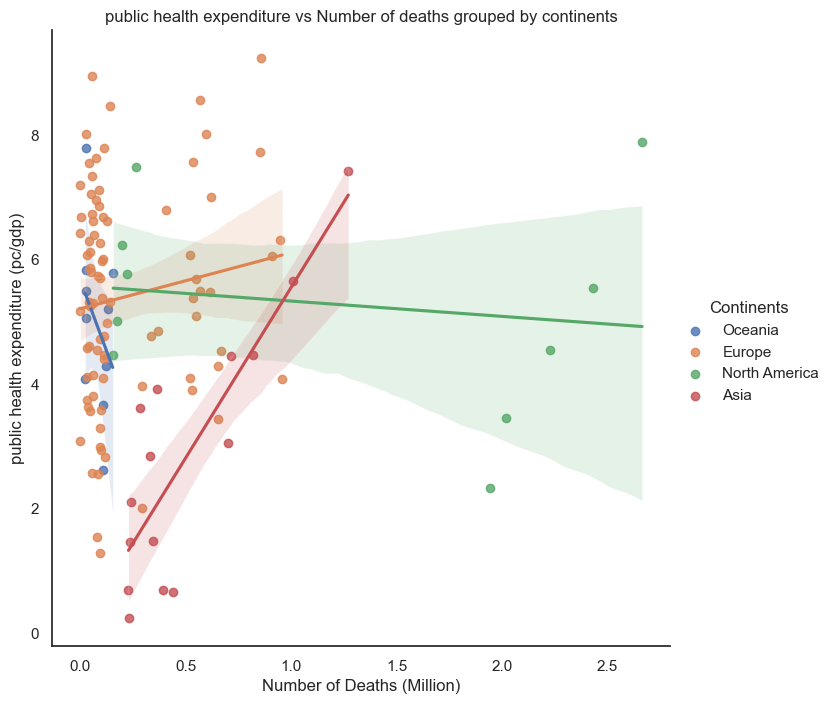

In [46]:
#public health expenditure vs Number of deaths
plt.figure(figsize=(12, 6))
g = sns.lmplot(
    data=GBD_public_health_df,
    y="public_health_expenditure_pc_gdp", x="Number of Deaths",
    height=7
)

plt.xlabel('Number of Deaths (Million)')
plt.ylabel('public health expenditure (pc/gdp)')
plt.title('public health expenditure vs Number of deaths', loc='center')


plt.show()

print(pearsonr(GBD_public_health_df['public_health_expenditure_pc_gdp'], GBD_public_health_df['Number of Deaths']))

#public health expenditure vs Number of deaths grouped by continents
plt.figure(figsize=(12, 6))
g = sns.lmplot(
    data=GBD_public_health_df,
    y="public_health_expenditure_pc_gdp", x="Number of Deaths", hue='Continents',
    height=7
)

plt.xlabel('Number of Deaths (Million)')
plt.ylabel('public health expenditure (pc/gdp)')
plt.title('public health expenditure vs Number of deaths grouped by continents', loc='center')


plt.show()
#Need to include person coeffient

### Weak/no correlation, regardles of grouping based on year. The reason for this is, regardless of wheter or not health expenditure is high, it depends on wheter or not the public use the service provided. If individuals don't utilise the service or are not seen as eligeible to the service, number of deaths will still increase.

## all diseases and number of deaths.

### Cleaning all_causes_df dataset

In [47]:
# Remove unesscary coloumns.
# Rename columns
# Clean countries columns
all_causes_df_cleaning = all_causes_df.copy()
all_causes_df_cleaning = all_causes_df_cleaning.drop(columns=['measure_id', 'measure_name', 'sex_id', 'cause_id', 'cause_name', 'age_id'])
all_causes_df_cleaning = all_causes_df_cleaning.rename(columns={'Entity':'Locations', 'sex_name':'Sex', 'age_name':'Ages', 'val':'Average_value', 'upper':'Upper_value', 'lower':'Lower_value'})
all_causes_df_cleaning


world = awoc.AWOC()
countries = world.get_countries()
list_of_countries = []
for country in countries:
    list_of_countries.append(country['Country Name'])
list_of_countries

missing_countries = []    
for country_name in all_causes_df_cleaning['Locations'].unique():
    if country_name not in list_of_countries:
#        print(f"{country_name} is NOT in the list.")
        missing_countries.append(country_name)
missing_countries

corrections = {
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    "Côte d'Ivoire": 'Ivory Coast',
    'Czechia': 'Czech Republic',
    'Eswatini': 'Swaziland',
    'Micronesia (Federated States of)': 'Micronesia',
    'Iran (Islamic Republic of)': 'Iran',
    'Republic of Moldova': 'Moldova',
    'Republic of Korea': 'South Korea',
    "Lao People's Democratic Republic": 'Laos',
    "Democratic People's Republic of Korea": 'North Korea',
    'Russian Federation': 'Russia',
    'Syrian Arab Republic': 'Syria',
    "Taiwan (Province of China)" : 'Taiwan',
    'Timor-Leste': 'East Timor',
    'United Republic of Tanzania': 'Tanzania',
    "United States of America": 'United States',
    'United States Virgin Islands': 'U.S. Virgin Islands',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Viet Nam': 'Vietnam'
    
}

all_causes_df_cleaning['Locations'] = all_causes_df_cleaning['Locations'].replace(corrections)
'Cape Verde' in list(all_causes_df_cleaning['Locations'].unique())

#Due to not being able to identify which congo is being refered to in this dataframe, I have not made any corrections to this countr.





True

In [48]:
#remove percent row and replace with percentage change column.
#Remove rate row, I don't think it is needed.
#I might add the average value, upper vale, lower value columns together.
#Order the data based on country and year.
all_causes_df_cleaning = all_causes_df_cleaning[all_causes_df_cleaning['metric_id'] == 1] 
all_causes_df_cleaning = all_causes_df_cleaning.sort_values(['Locations', 'Year']) 
all_causes_df_cleaning


k = list(Global_Burden_of_Disease_df_country['Country Name'].unique())
country_names_change = all_causes_df_cleaning[~all_causes_df_cleaning['Locations'].isin(k)]
print(country_names_change['Locations'].unique())
#Checking the number of locations for the 2 dataframes.
print(len(Global_Burden_of_Disease_df_country['Country Name'].unique()))
print(len(all_causes_df_cleaning['Locations'].unique()))
#Delete locations from all_causes_df_cleaning dataframe that do not show up in global burden of disease datframe.
country_names_change = list(country_names_change['Locations'].unique())


#all_causes_df_cleaning['Locations'] = all_causes_df_cleaning['Locations'].drop(country_names_change)
all_causes_df_cleaning = all_causes_df_cleaning[~all_causes_df_cleaning['Locations'].isin(country_names_change)]
# Figiure out which country in Global burden of disease is not in all causes datframe.
original_df = list(all_causes_df_cleaning['Locations'].unique())
names_change = Global_Burden_of_Disease_df_country[~Global_Burden_of_Disease_df_country['Country Name'].isin(original_df)]
names_change
# I will ned to remove this country from global burden of disease dataframe.
GBD_all_causes = Global_Burden_of_Disease_df_country.copy()
GBD_all_causes = GBD_all_causes[GBD_all_causes['Country Name'] != 'Republic of the Congo']
print(len(GBD_all_causes['Country Name'].unique()))
print(len(all_causes_df_cleaning['Locations'].unique()))
# Remove 1970 year from GBD_all_causes dataframe
GBD_all_causes = GBD_all_causes[GBD_all_causes['Year'] != 1970]
# Add percentage change to all_causes_df_cleaning dataframe.

# Need to merge all_causes_df_cleaning and GBD_all_causes, so I can compare the data.
GBD_all_causes
GBD_every_disease_df = pd.merge(GBD_all_causes, all_causes_df_cleaning,  how='left', left_on=['Year','Country Name'], right_on = ['Year','Locations'])
GBD_every_disease_df = GBD_every_disease_df.drop(columns=['Country Code', 'location_id','Locations', 'Sex_y', 'Ages', 'metric_id', 'Age Group', 'Sex_x', 'metric_name'])
GBD_every_disease_df

#Convert to million
GBD_every_disease_df['Average_value'] = GBD_every_disease_df['Average_value'].apply(convert_to_million)
GBD_every_disease_df['Number of Deaths'] = GBD_every_disease_df['Number of Deaths'].apply(convert_to_million)



['American Samoa' 'Bermuda' 'Congo' 'Cook Islands' 'Greenland' 'Guam'
 'Monaco' 'Nauru' 'Niue' 'Northern Mariana Islands' 'Palau' 'Puerto Rico'
 'Saint Kitts and Nevis' 'San Marino' 'South Sudan' 'Tokelau' 'Tuvalu'
 'U.S. Virgin Islands']
187
204
186
186


In [49]:
k = list(healthcare_expenditure_vs_gdp_df_cleaning['Country_name'].unique())
country_names_change = all_causes_df_cleaning[~all_causes_df_cleaning['Locations'].isin(k)]
print(country_names_change['Locations'].unique())
#Checking the number of locations for the 2 dataframes.
print(len(healthcare_expenditure_vs_gdp_df_cleaning['Country_name'].unique()))
print(len(all_causes_df_cleaning['Locations'].unique()))
#Delete locations from all_causes_df_cleaning dataframe that do not show up in global burden of disease datframe.
country_names_change = list(country_names_change['Locations'].unique())




[]
187
186
186
186


In [ ]:


#all_causes_df_cleaning['Locations'] = all_causes_df_cleaning['Locations'].drop(country_names_change)
all_causes_df_cleaning = all_causes_df_cleaning[~all_causes_df_cleaning['Locations'].isin(country_names_change)]
# Figiure out which country in Global burden of disease is not in all causes datframe.
original_df = list(all_causes_df_cleaning['Locations'].unique())
names_change = healthcare_expenditure_vs_gdp_df_cleaning[~healthcare_expenditure_vs_gdp_df_cleaning['Country_name'].isin(original_df)]
names_change
# I will ned to remove this country from global burden of disease dataframe.
healthcare_all_causes = healthcare_expenditure_vs_gdp_df_cleaning.copy()
healthcare_all_causes = healthcare_all_causes[healthcare_all_causes['Country_name'] != 'Republic of the Congo']
print(len(healthcare_all_causes['Country_name'].unique()))
print(len(all_causes_df_cleaning['Locations'].unique()))
# Remove 1970 year from GBD_all_causes dataframe
healthcare_all_causes = healthcare_all_causes[healthcare_all_causes['Year'] != 1970]
# merging population dataframe and all causes together
pop_every_disease_df = pd.merge(healthcare_all_causes, all_causes_df_cleaning,  how='left', left_on=['Year','Country_name'], right_on = ['Year','Locations'])
pop_every_disease_df = pop_every_disease_df.drop(columns=['Country_code','Current health expenditure per capita, PPP (current international $)',
       'GDP per capita, PPP (constant 2017 international $)', 'location_id','Sex',
       'Ages', 'metric_id', 'metric_name' ])
pop_every_disease_df

#Convert values to million
pop_every_disease_df['Average_value'] = pop_every_disease_df['Average_value'].apply(convert_to_million)
pop_every_disease_df['Population (historical estimates)'] = pop_every_disease_df['Population (historical estimates)'].apply(convert_to_million)



### All causes visualisation and analysis
#### All causes and Number of deaths
#### All causes and number of population

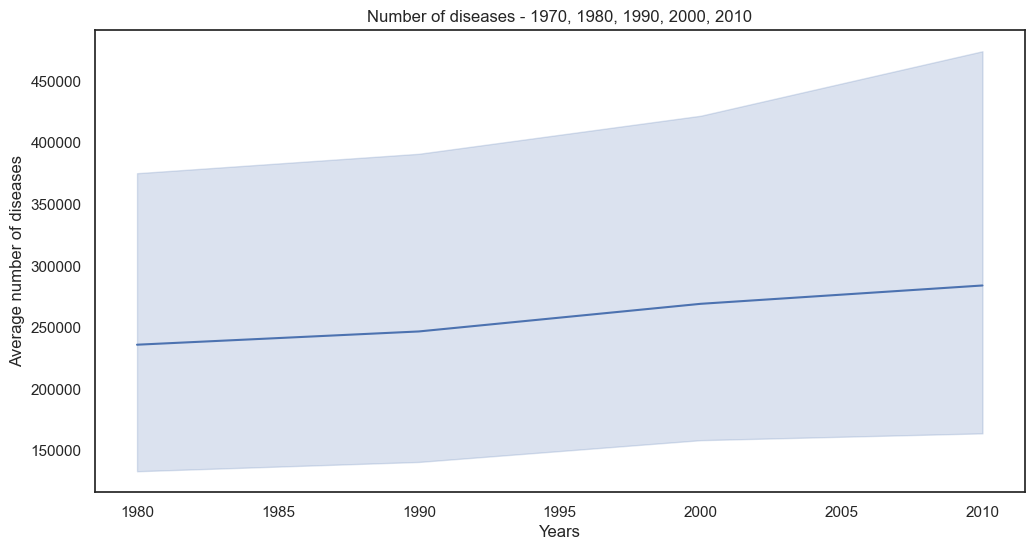

In [50]:
#Net I will need to merge the dataframe and visualise the data.
#Also, I will need to find out the correlation between the number of deaths and number of diseases throughout the years.
#Null hupothesis: There is no correlation between both.
plt.figure(figsize=(12, 6))
sns.lineplot(x="Year", y="Average_value", data=all_causes_df_cleaning)
#
plt.xlabel('Years')
plt.ylabel('Average number of diseases')
plt.title('Number of diseases - 1970, 1980, 1990, 2000, 2010', loc='center')


plt.show()


<Figure size 500x600 with 0 Axes>

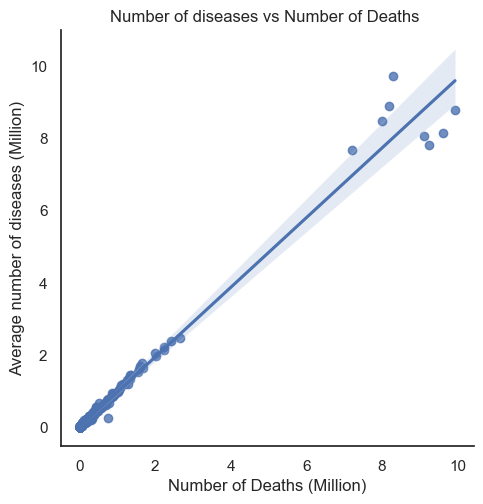

<Figure size 500x600 with 0 Axes>

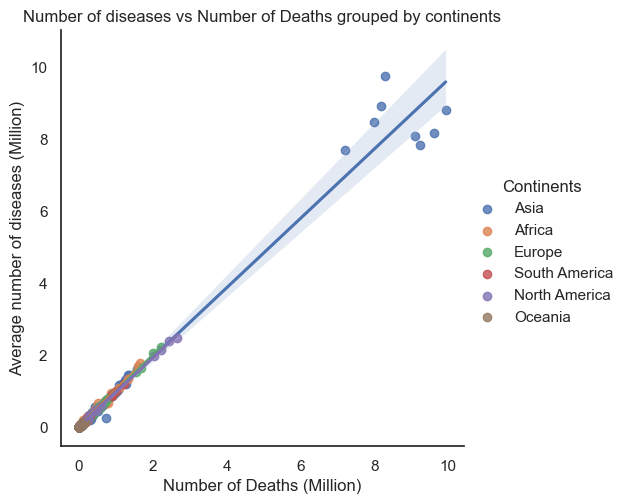

PearsonRResult(statistic=0.9843818251313584, pvalue=0.0)


<Figure size 500x600 with 0 Axes>

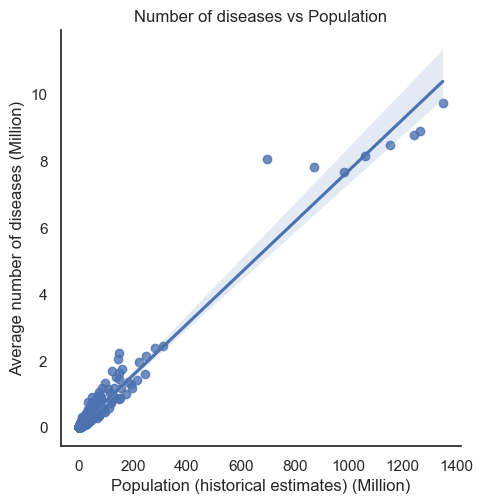

In [51]:
#Number of diseases vs Number of Deaths
plt.figure(figsize=(5, 6))
g = sns.lmplot(
    data=GBD_every_disease_df,
    y="Average_value", x="Number of Deaths"

)

plt.xlabel('Number of Deaths (Million)')
plt.ylabel('Average number of diseases (Million)')
plt.title('Number of diseases vs Number of Deaths ', loc='center')


plt.show()

#print(pearsonr(pop_every_disease_df['Average_value'], pop_every_disease_df['Number of Deaths']))

#Number of diseases vs Number of Deaths grouped by continents
plt.figure(figsize=(5, 6))
g = sns.lmplot(
    data=GBD_every_disease_df,
    y="Average_value", x="Number of Deaths", hue='Continents'
    
)

plt.xlabel('Number of Deaths (Million)')
plt.ylabel('Average number of diseases (Million)')
plt.title('Number of diseases vs Number of Deaths grouped by continents', loc='center')


plt.show()

#print(pearsonr(pop_every_disease_df['Average_value'], pop_every_disease_df['Number of Deaths']))

#Number of diseases vs Population
plt.figure(figsize=(5, 6))
g = sns.lmplot(
    data=pop_every_disease_df,
    y="Average_value", x="Population (historical estimates)"
    
)

plt.xlabel('Population (historical estimates) (Million)')
plt.ylabel('Average number of diseases (Million)')
plt.title('Number of diseases vs Population', loc='center')

print(pearsonr(pop_every_disease_df['Average_value'], pop_every_disease_df['Population (historical estimates)']))

plt.show()



## Specific disease data frame cleaning

In [52]:
# remove unessary columns
#rename columns.
# Double check to see if there are any repeat in the disease name.
# move percent and rate rows.
# Double check countries
# make sure the same number of countries in Global burden of diseases is in this datframe.
# Check to see how many disease each country have -> it should be thae same number.

In [53]:
# Remove unesscary columns
# Rename columns
# Order dataframe based on country and year
# Remove rate and percent rows

specific_causes_df_cleaning = specific_causes_df.copy()

specific_causes_df_cleaning = specific_causes_df_cleaning.drop(columns=['measure_id', 'measure_name', 'age_id', 'sex_id', 'location_id', 'cause_id'])

specific_causes_df_cleaning = specific_causes_df_cleaning.rename(columns={'Entity':'Country', 'sex_name':'Sex', 'age_name':'Age', 'cause_name':'Disease', 'val':'Average_value', 'upper':'Upper_value', 'lower':'Lower_value'})                                 

specific_causes_df_cleaning = specific_causes_df_cleaning.sort_values(['Country', 'Year']) 

specific_causes_df_cleaning = specific_causes_df_cleaning[specific_causes_df_cleaning['metric_name'] == 'Number']
specific_causes_df_cleaning


                                 

Country   Sex       Age  \
63757   Afghanistan  Both  All ages   
63760   Afghanistan  Both  All ages   
63763   Afghanistan  Both  All ages   
63766   Afghanistan  Both  All ages   
63769   Afghanistan  Both  All ages   
...             ...   ...       ...   
489614     Zimbabwe  Both  All ages   
489617     Zimbabwe  Both  All ages   
489620     Zimbabwe  Both  All ages   
489623     Zimbabwe  Both  All ages   
489626     Zimbabwe  Both  All ages   

                                                  Disease  metric_id  \
63757                HIV/AIDS resulting in other diseases          1   
63760                                  Diarrheal diseases          1   
63763                                       Typhoid fever          1   
63766                                   Paratyphoid fever          1   
63769                Other intestinal infectious diseases          1   
...                                                   ...        ...   
489614                 Other benign and in situ neoplasms          1   
489617        Non-rheumatic calcific aortic valve disease          1   
489620    Non-rheumatic degenerative mitral valve disease          1   
489623                 Other non-rheumatic valve diseases          1   
489626  Nonalcoholic fatty liver disease including cir...          1   

       metric_name  Year  Average_value   Upper_value   Lower_value  
63757       Number  1980       3.235869     15.969942      0.000000  
63760       Number  1980   16761.408091  23231.356224  10390.568877  
63763       Number  1980     349.359630    679.187318    147.968004  
63766       Number  1980       2.364208      5.196229      0.881690  
63769       Number  1980      60.343495     87.911840     42.135062  
...            ...   ...            ...           ...           ...  
489614      Number  2010       0.004416      0.006355      0.002651  
489617      Number  2010      52.825242     67.867411     39.459861  
489620      Number  2010      44.005224     60.891111     25.236570  
489623      Number  2010       1.144953      1.921587      0.612153  
489626      Number  2010      84.946525    136.542943     46.689023  

[166664 rows x 10 columns]

In [54]:
list_of_countries

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos Islands',
 'Colombia',
 'Comoros',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethi

In [55]:
# Make sure specific_causes_df_cleaning has the same countries as global burden of disease datframe.
world = awoc.AWOC()
countries = world.get_countries()
list_of_countries = []
for country in countries:
    list_of_countries.append(country['Country Name'])
list_of_countries

missing_countries = []    
for country_name in specific_causes_df_cleaning['Country'].unique():
    if country_name not in list_of_countries:
#        print(f"{country_name} is NOT in the list.")
        missing_countries.append(country_name)
missing_countries

corrections = {
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    "Côte d'Ivoire": 'Ivory Coast',
    'Czechia': 'Czech Republic',
    'Eswatini': 'Swaziland',
    'Micronesia (Federated States of)': 'Micronesia',
    'North Macedonia': 'North Macedonia',
    'Iran (Islamic Republic of)': 'Iran',
    'Republic of Moldova': 'Moldova',
    'Republic of Korea': 'South Korea',
    "Lao People's Democratic Republic": 'Laos',
    "Democratic People's Republic of Korea": 'North Korea',
    'Russian Federation': 'Russia',
    'Syrian Arab Republic': 'Syria',
    "Taiwan (Province of China)" : 'Taiwan',
    'Timor-Leste': 'East Timor',
    'Türkiye': 'Turkey',
    'United Republic of Tanzania': 'Tanzania',
    "United States of America": 'United States',
    'United States Virgin Islands': 'U.S. Virgin Islands',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Viet Nam': 'Vietnam'
    
}

specific_causes_df_cleaning['Country'] = specific_causes_df_cleaning['Country'].replace(corrections)
'Vietnam' in list(specific_causes_df_cleaning['Country'].unique())
# Name the same as global burden datafream.


GBD_specific_causes = Global_Burden_of_Disease_df_country.copy()
GBD_countries = list(GBD_specific_causes['Country Name'].unique())
specific_causes_df_cleaning = specific_causes_df_cleaning[specific_causes_df_cleaning['Country'].isin(GBD_countries)]
print('GBD DATAFRAME',len(GBD_specific_causes['Country Name'].unique()))
print('Specific causes dataframe',len(specific_causes_df_cleaning['Country'].unique()))




GBD DATAFRAME 187
Specific causes dataframe 186


In [56]:
#What countries are in specific causes dataframes, that are not in global burden of diseases.
scd_countries = specific_causes_df_cleaning['Country'].unique() 
GBD_specific_causes[~GBD_specific_causes['Country Name'].isin(scd_countries)]
GBD_specific_causes = GBD_specific_causes[GBD_specific_causes['Country Name'] != 'Republic of the Congo']
print('GBD DATAFRAME updated', len(GBD_specific_causes['Country Name'].unique()))
print('Specific causes dataframe updated', len(specific_causes_df_cleaning['Country'].unique()))


GBD DATAFRAME updated 186
Specific causes dataframe updated 186


In [57]:
#Removing 1970
GBD_specific_causes = GBD_specific_causes[GBD_specific_causes['Year'] != 1970]
GBD_specific_causes

#Merging dataframes
GBD_specific_disease_df = pd.merge(GBD_specific_causes, specific_causes_df_cleaning,  how='left', left_on=['Year','Country Name'], right_on = ['Year','Country'])
GBD_specific_disease_df.columns
GBD_specific_disease_df = GBD_specific_disease_df.drop(columns=['Country Code', 'Country', 'Sex_y', 'Age', 'metric_id', 'Age Group', 'Sex_x', 'metric_name'])
GBD_specific_disease_df



Country Name  Year  Number of Deaths  Death Rate Per 100,000  \
0       Afghanistan  1980            292045                  2026.8   
1       Afghanistan  1980            292045                  2026.8   
2       Afghanistan  1980            292045                  2026.8   
3       Afghanistan  1980            292045                  2026.8   
4       Afghanistan  1980            292045                  2026.8   
...             ...   ...               ...                     ...   
153501     Zimbabwe  2010            159430                  1264.9   
153502     Zimbabwe  2010            159430                  1264.9   
153503     Zimbabwe  2010            159430                  1264.9   
153504     Zimbabwe  2010            159430                  1264.9   
153505     Zimbabwe  2010            159430                  1264.9   

       Number of Deaths pct change Death Rate Per 100,000 pct change  \
0                           0.071%                          -16.671%   
1                           0.071%                          -16.671%   
2                           0.071%                          -16.671%   
3                           0.071%                          -16.671%   
4                           0.071%                          -16.671%   
...                            ...                               ...   
153501                     -5.042%                           -5.364%   
153502                     -5.042%                           -5.364%   
153503                     -5.042%                           -5.364%   
153504                     -5.042%                           -5.364%   
153505                     -5.042%                           -5.364%   

       Continents                                            Disease  \
0            Asia               HIV/AIDS resulting in other diseases   
1            Asia                                 Diarrheal diseases   
2            Asia                                      Typhoid fever   
3            Asia                                  Paratyphoid fever   
4            Asia               Other intestinal infectious diseases   
...           ...                                                ...   
153501     Africa                 Other benign and in situ neoplasms   
153502     Africa        Non-rheumatic calcific aortic valve disease   
153503     Africa    Non-rheumatic degenerative mitral valve disease   
153504     Africa                 Other non-rheumatic valve diseases   
153505     Africa  Nonalcoholic fatty liver disease including cir...   

        Average_value   Upper_value   Lower_value  
0            3.235869     15.969942      0.000000  
1        16761.408091  23231.356224  10390.568877  
2          349.359630    679.187318    147.968004  
3            2.364208      5.196229      0.881690  
4           60.343495     87.911840     42.135062  
...               ...           ...           ...  
153501       0.004416      0.006355      0.002651  
153502      52.825242     67.867411     39.459861  
153503      44.005224     60.891111     25.236570  
153504       1.144953      1.921587      0.612153  
153505      84.946525    136.542943     46.689023  

[153506 rows x 11 columns]

In [58]:
#Checking dataframe for any Nan values.
#If nan values are present, I will rectify them based on how they were developed.
#From looking at the original dataframe, it seems the nan values are due to the fact that ther were no data for these countries and year.
#AS a result of this, I will be removing these nan values from my dataframe.
display(GBD_specific_disease_df.isna().sum())
nan_values = GBD_specific_disease_df[GBD_specific_disease_df.isna().any(axis=1)]
display(nan_values)
nan_values['Country Name'].unique()
Nigeria = specific_causes_df_cleaning[specific_causes_df_cleaning['Country'] == 'Nigeria']
display(Nigeria[Nigeria['Year'] == 2010])
Pakistan = specific_causes_df_cleaning[specific_causes_df_cleaning['Country'] == 'Pakistan']
# Make a dataframe containing all the above countries and check to see if they have 2010


Country Name                          0
Year                                  0
Number of Deaths                      0
Death Rate Per 100,000                0
Number of Deaths pct change           0
Death Rate Per 100,000 pct change     0
Continents                            0
Disease                              13
Average_value                        13
Upper_value                          13
Lower_value                          13
dtype: int64

Country Name  Year  Number of Deaths  Death Rate Per 100,000  \
27135                   Chile  2010             96913                   591.2   
70229                 Jamaica  2010             17247                   627.3   
79471                 Liberia  2010             43052                  1083.2   
80926             Saint Lucia  2010              1175                   675.2   
91378                    Mali  2010            171168                  1107.0   
96318              Mauritania  2010             23612                   679.7   
100223                  Niger  2010            178992                  1151.3   
100920                Nigeria  2010           1641390                  1033.7   
104073                  Nepal  2010            164915                   550.3   
106449               Pakistan  2010           1244753                   717.1   
107146                 Panama  2010             16592                   471.7   
125666  Sao Tome and Principe  2010               878                   527.2   
144465                Uruguay  2010             32217                   955.3   

       Number of Deaths pct change Death Rate Per 100,000 pct change  \
27135                      20.229%                            9.868%   
70229                       3.623%                           -2.744%   
79471                      15.756%                          -17.883%   
80926                       3.433%                           -6.521%   
91378                      -5.816%                          -31.268%   
96318                       6.822%                           -18.55%   
100223                       1.95%                          -28.196%   
100920                      2.964%                          -19.725%   
104073                     -4.362%                          -22.098%   
106449                      7.145%                          -10.831%   
107146                     39.078%                           16.902%   
125666                    -13.412%                          -26.829%   
144465                      1.737%                            0.178%   

           Continents Disease  Average_value  Upper_value  Lower_value  
27135   South America     NaN            NaN          NaN          NaN  
70229   North America     NaN            NaN          NaN          NaN  
79471          Africa     NaN            NaN          NaN          NaN  
80926   North America     NaN            NaN          NaN          NaN  
91378          Africa     NaN            NaN          NaN          NaN  
96318          Africa     NaN            NaN          NaN          NaN  
100223         Africa     NaN            NaN          NaN          NaN  
100920         Africa     NaN            NaN          NaN          NaN  
104073           Asia     NaN            NaN          NaN          NaN  
106449           Asia     NaN            NaN          NaN          NaN  
107146  North America     NaN            NaN          NaN          NaN  
125666         Africa     NaN            NaN          NaN          NaN  
144465  South America     NaN            NaN          NaN          NaN

Empty DataFrame
Columns: [Country, Sex, Age, Disease, metric_id, metric_name, Year, Average_value, Upper_value, Lower_value]
Index: []

In [59]:
#Removing the above nan values
GBD_specific_disease_df = GBD_specific_disease_df.dropna()
nan_values_removed = GBD_specific_disease_df[GBD_specific_disease_df.isna().any(axis=1)]
display(nan_values_removed)

Empty DataFrame
Columns: [Country Name, Year, Number of Deaths, Death Rate Per 100,000, Number of Deaths pct change, Death Rate Per 100,000 pct change, Continents, Disease, Average_value, Upper_value, Lower_value]
Index: []

In [60]:
#Convert average value to million
GBD_specific_disease_df['Average_value'] = GBD_specific_disease_df['Average_value'].apply(convert_to_million)

#Spliting dataframe based on continents
GBD_specific_disease_asia = GBD_specific_disease_df[GBD_specific_disease_df['Continents'] == 'Asia']
GBD_specific_disease_africa = GBD_specific_disease_df[GBD_specific_disease_df['Continents'] == 'Africa']
GBD_specific_disease_europe = GBD_specific_disease_df[GBD_specific_disease_df['Continents'] == 'Europe']
GBD_specific_disease_southamerica = GBD_specific_disease_df[GBD_specific_disease_df['Continents'] == 'South America']
GBD_specific_disease_northamerica = GBD_specific_disease_df[GBD_specific_disease_df['Continents'] == 'North America']
GBD_specific_disease_oceania = GBD_specific_disease_df[GBD_specific_disease_df['Continents'] == 'Oceania']


#Spliting dataframe based on Year asia
GBD_specific_disease_asia_80 = GBD_specific_disease_asia[GBD_specific_disease_asia['Year'] == 1980]
GBD_specific_disease_asia_90 = GBD_specific_disease_asia[GBD_specific_disease_asia['Year'] == 1990]
GBD_specific_disease_asia_00 = GBD_specific_disease_asia[GBD_specific_disease_asia['Year'] == 2000]
GBD_specific_disease_asia_10 = GBD_specific_disease_asia[GBD_specific_disease_asia['Year'] == 2010]

#Spliting dataframe based on Year africa
GBD_specific_disease_africa_80 = GBD_specific_disease_africa[GBD_specific_disease_africa['Year'] == 1980]
GBD_specific_disease_africa_90 = GBD_specific_disease_africa[GBD_specific_disease_africa['Year'] == 1990]
GBD_specific_disease_africa_00 = GBD_specific_disease_africa[GBD_specific_disease_africa['Year'] == 2000]
GBD_specific_disease_africa_10 = GBD_specific_disease_africa[GBD_specific_disease_africa['Year'] == 2010]

#Spliting dataframe based on Year south america
GBD_specific_disease_southamerica_80 = GBD_specific_disease_southamerica[GBD_specific_disease_southamerica['Year'] == 1980]
GBD_specific_disease_southamerica_90 = GBD_specific_disease_southamerica[GBD_specific_disease_southamerica['Year'] == 1990]
GBD_specific_disease_southamerica_00 = GBD_specific_disease_southamerica[GBD_specific_disease_southamerica['Year'] == 2000]
GBD_specific_disease_southamerica_10 = GBD_specific_disease_southamerica[GBD_specific_disease_southamerica['Year'] == 2010]

#Spliting dataframe based on Year europe
GBD_specific_disease_europe_80 = GBD_specific_disease_europe[GBD_specific_disease_europe['Year'] == 1980]
GBD_specific_disease_europe_90 = GBD_specific_disease_europe[GBD_specific_disease_europe['Year'] == 1990]
GBD_specific_disease_europe_00 = GBD_specific_disease_europe[GBD_specific_disease_europe['Year'] == 2000]
GBD_specific_disease_europe_10 = GBD_specific_disease_europe[GBD_specific_disease_europe['Year'] == 2010]

#Spliting dataframe based on Year north america
GBD_specific_disease_northamerica_80 = GBD_specific_disease_northamerica[GBD_specific_disease_northamerica['Year'] == 1980]
GBD_specific_disease_northamerica_90 = GBD_specific_disease_northamerica[GBD_specific_disease_northamerica['Year'] == 1990]
GBD_specific_disease_northamerica_00 = GBD_specific_disease_northamerica[GBD_specific_disease_northamerica['Year'] == 2000]
GBD_specific_disease_northamerica_10 = GBD_specific_disease_northamerica[GBD_specific_disease_northamerica['Year'] == 2010]

#Spliting dataframe based on Year oceania
GBD_specific_disease_oceania_80 = GBD_specific_disease_oceania[GBD_specific_disease_oceania['Year'] == 1980]
GBD_specific_disease_oceania_90 = GBD_specific_disease_oceania[GBD_specific_disease_oceania['Year'] == 1990]
GBD_specific_disease_oceania_00 = GBD_specific_disease_oceania[GBD_specific_disease_oceania['Year'] == 2000]
GBD_specific_disease_oceania_10 = GBD_specific_disease_oceania[GBD_specific_disease_oceania['Year'] == 2010]


### Visualise datframe for corrleation comparison

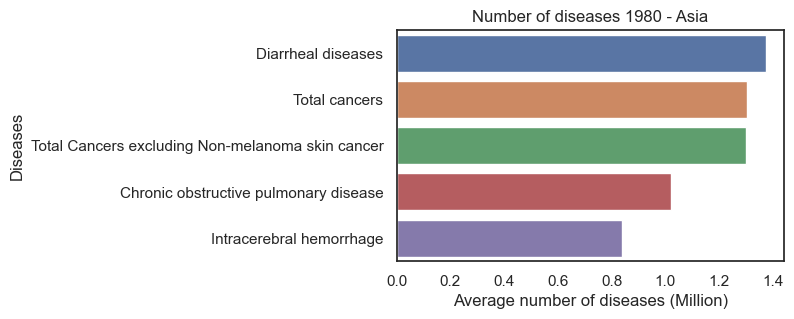

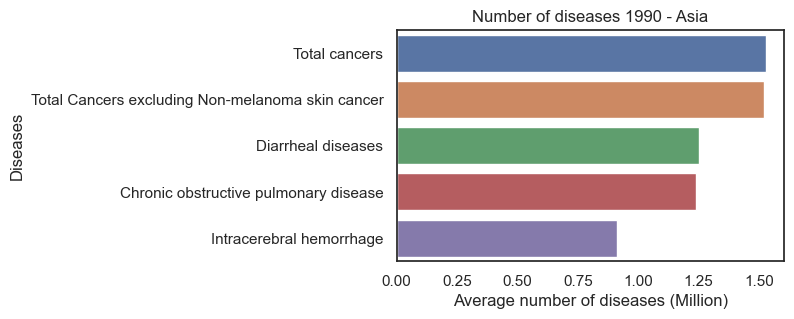

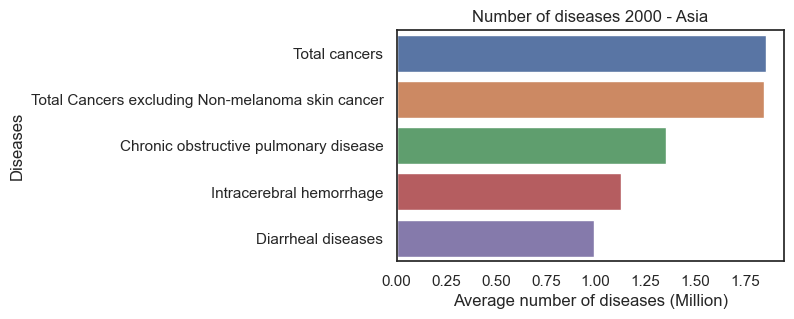

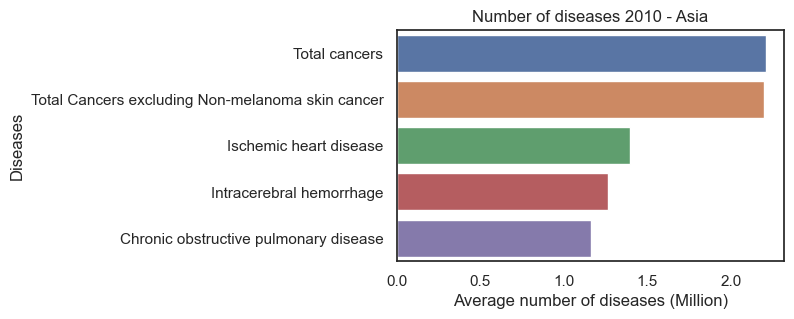

In [61]:
#Asia dieases 1970, 1980, 1990, 2000, 2010
plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_asia_80.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1980 - Asia', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_asia_90.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1990 - Asia', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_asia_00.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2000 - Asia', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_asia_10.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2010 - Asia', loc='center')


plt.show()

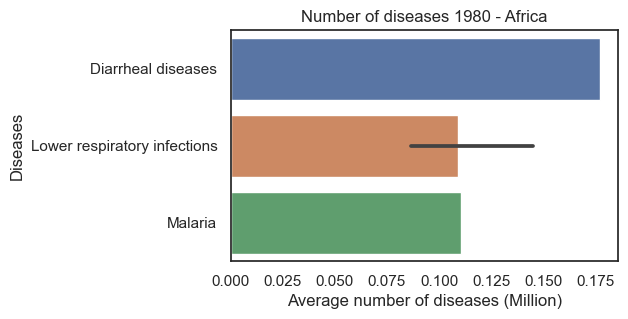

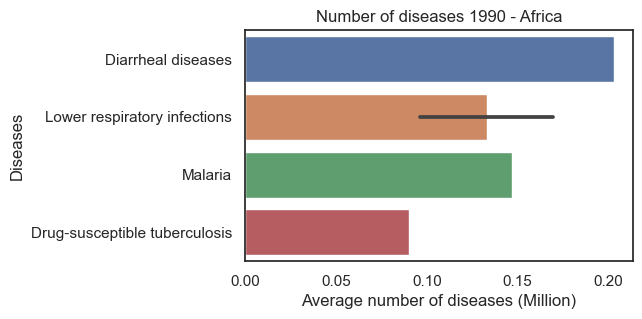

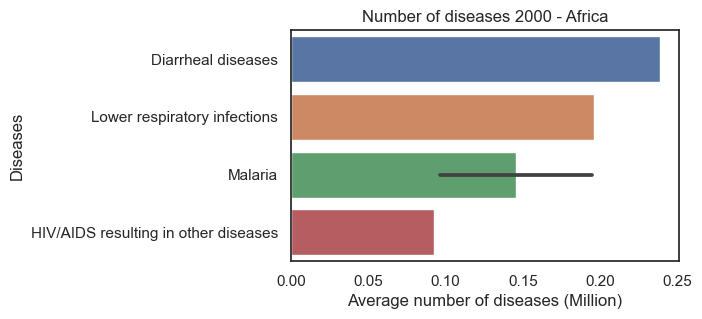

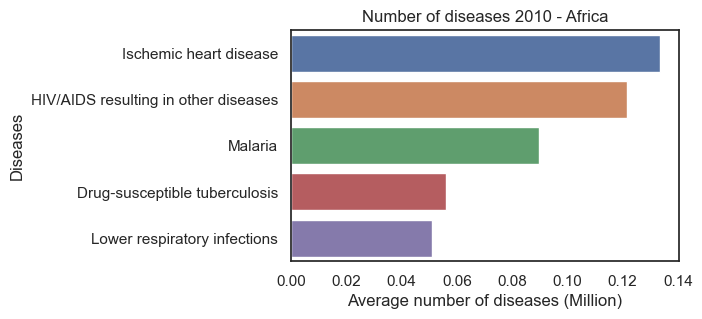

In [62]:
#Africa dieases 1970, 1980, 1990, 2000, 2010

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_africa_80.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1980 - Africa', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_africa_90.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1990 - Africa', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_africa_00.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2000 - Africa', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_africa_10.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2010 - Africa', loc='center')


plt.show()

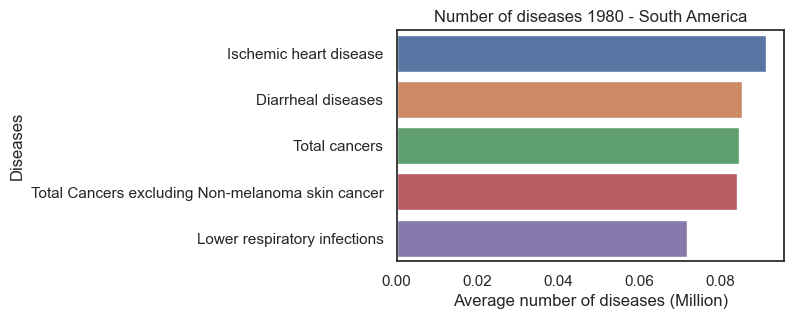

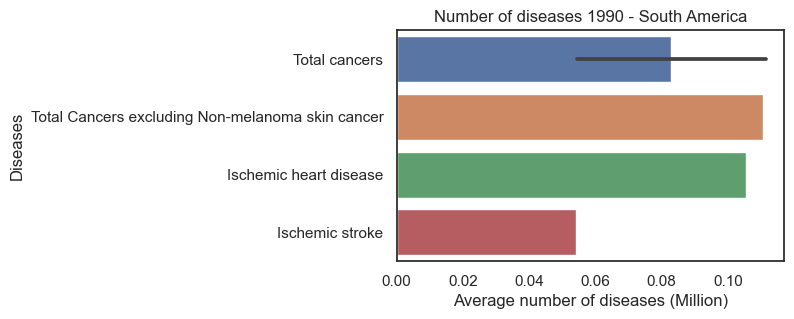

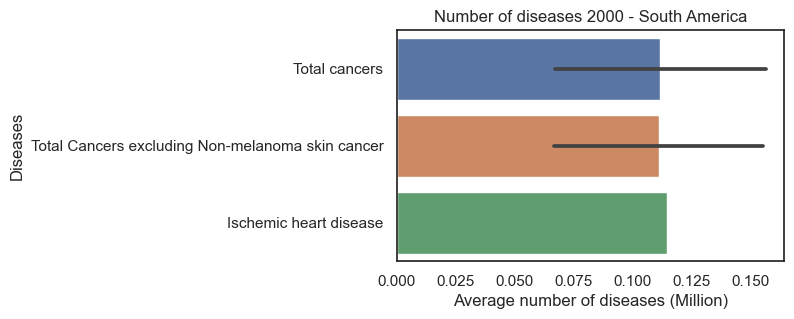

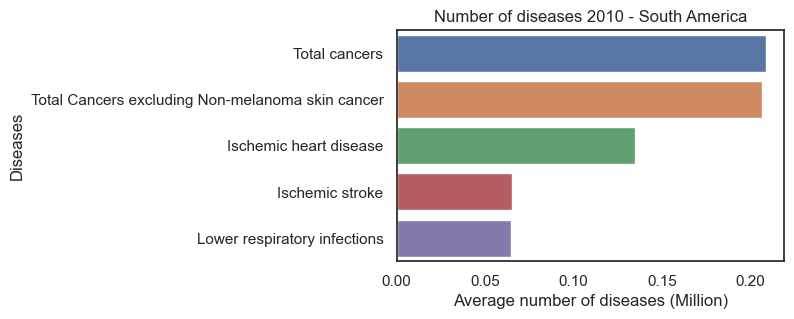

In [63]:
#South America dieases 1970, 1980, 1990, 2000, 2010

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_southamerica_80.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1980 - South America', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_southamerica_90.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1990 - South America', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_southamerica_00.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2000 - South America', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_southamerica_10.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2010 - South America', loc='center')


plt.show()

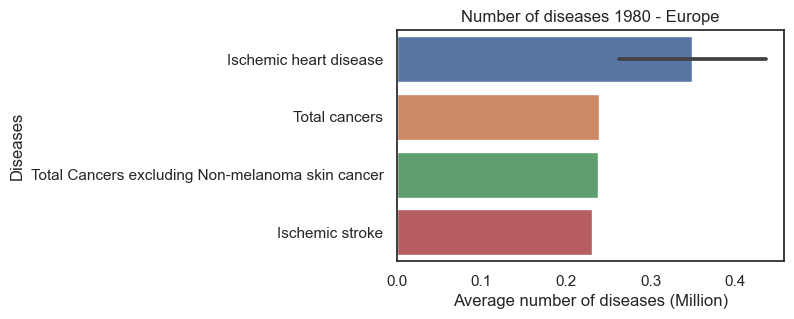

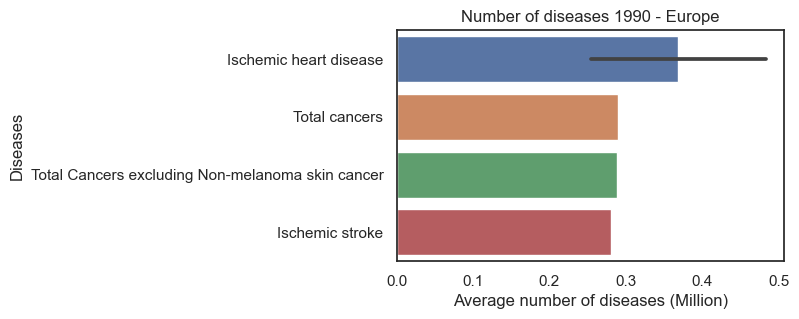

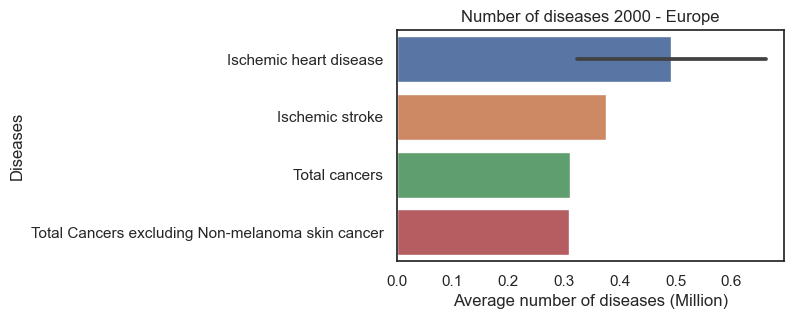

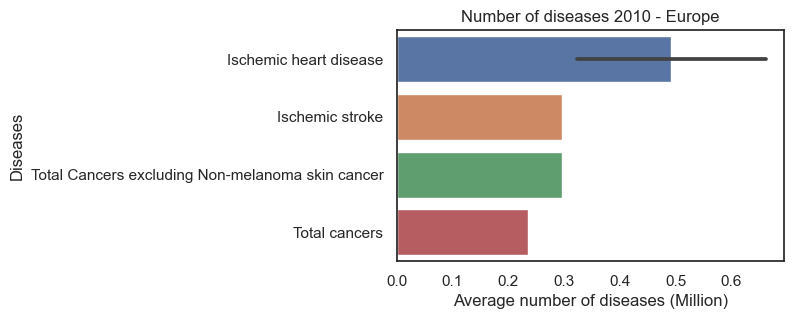

In [64]:
#Europe dieases 1970, 1980, 1990, 2000, 2010

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_europe_80.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1980 - Europe', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_europe_90.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1990 - Europe', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_europe_00.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2000 - Europe', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_europe_10.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2010 - Europe', loc='center')


plt.show()

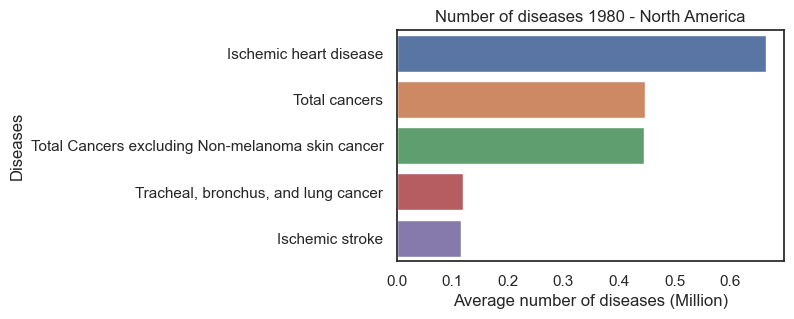

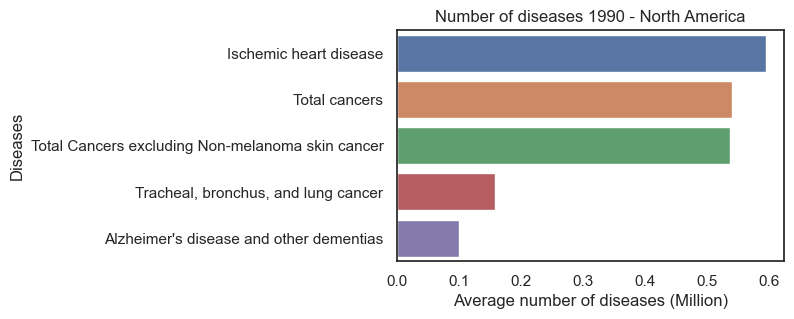

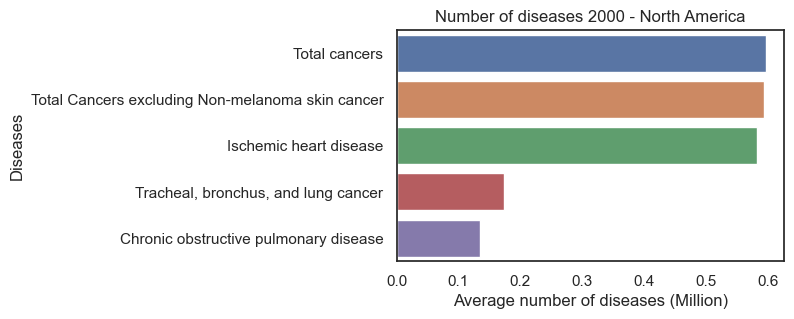

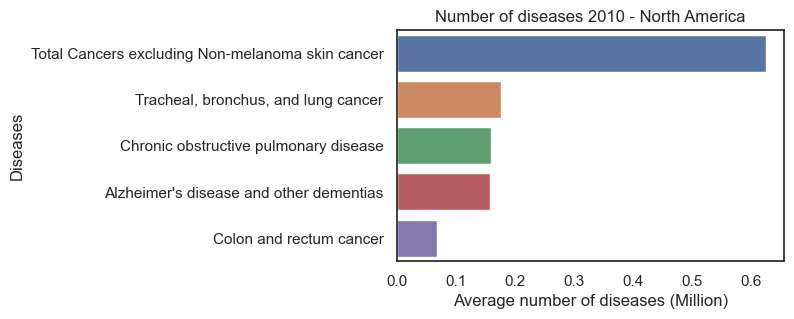

In [65]:
#North America dieases 1970, 1980, 1990, 2000, 2010

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_northamerica_80.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1980 - North America', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_northamerica_90.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1990 - North America', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_northamerica_00.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2000 - North America', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_northamerica_10.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2010 - North America', loc='center')


plt.show()

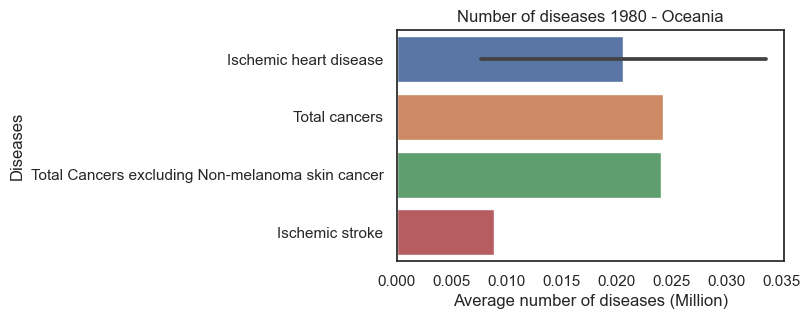

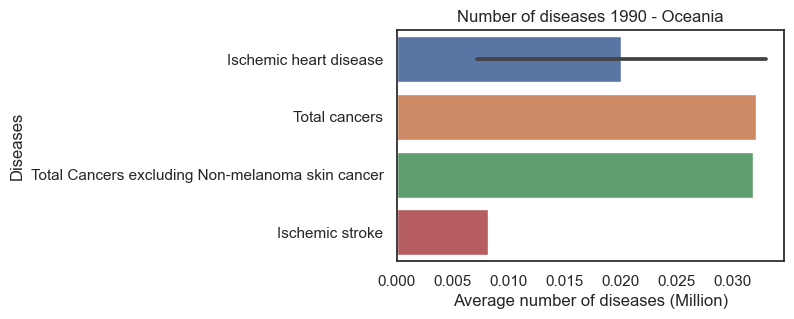

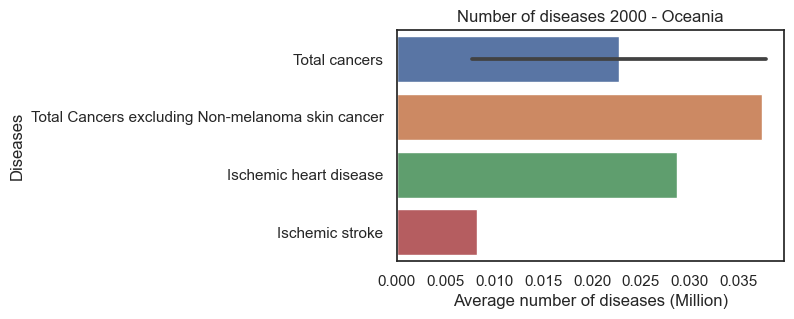

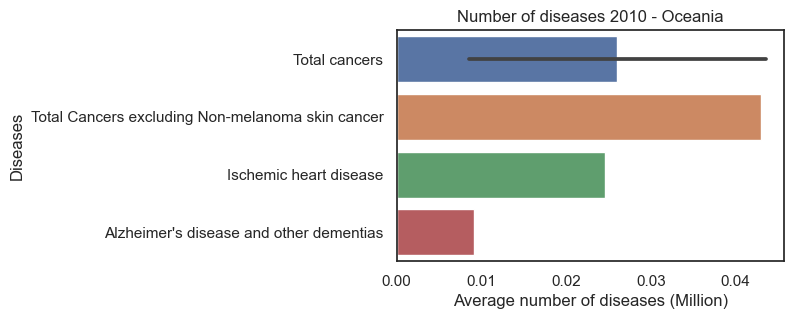

In [66]:


#Ocenia dieases 1970, 1980, 1990, 2000, 2010

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_oceania_80.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1980 - Oceania', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_oceania_90.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 1990 - Oceania', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_oceania_00.nlargest(5, 'Average_value')
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2000 - Oceania', loc='center')


plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_oceania_10.nlargest(5, 'Average_value')
)
plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases 2010 - Oceania', loc='center')


plt.show()

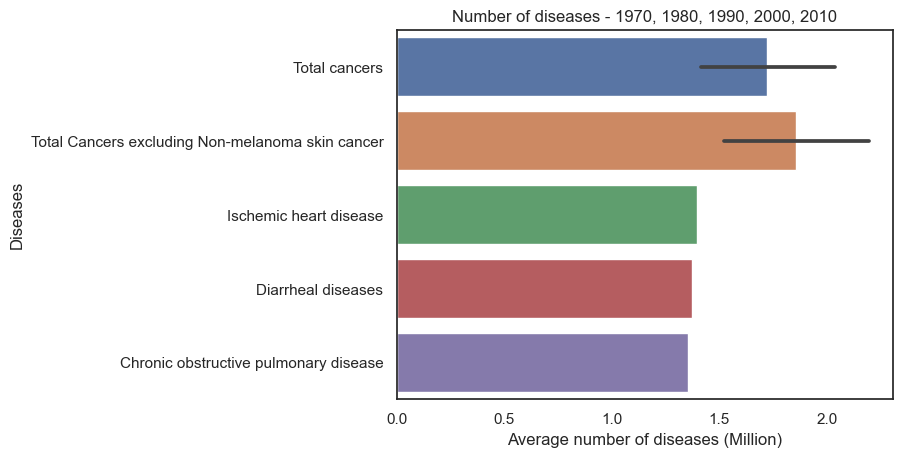

In [67]:



sns.barplot(
    y='Disease',
    x='Average_value',
    data=GBD_specific_disease_df.nlargest(10, 'Average_value')
    #order=GBD_specific_disease_df['Average_value']
)

plt.ylabel('Diseases')
plt.xlabel('Average number of diseases (Million)')
plt.title('Number of diseases - 1970, 1980, 1990, 2000, 2010', loc='center')


plt.show()